### Causal trees. Treatment effects estimation with synthetic data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
np.random.seed(42)


from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.meta import BaseSRegressor, BaseXRegressor, BaseTRegressor, BaseDRRegressor
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.inference.tree import CausalTreeRegressor


import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

Failed to import duecredit due to No module named 'duecredit'


In [2]:
causalml.__version__

'0.13.0'

In [3]:
# Simulate randomized trial: mode=2
y, X, w, tau, b, e = synthetic_data(mode=2, n=10000, p=20, sigma=5.0)

df = pd.DataFrame(X)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df.columns = feature_names
df['outcome'] = y
df['treatment'] = w
df['treatment_effect'] = tau

In [4]:
df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.358450   1.523030  -0.234153  -0.234137   
1   1.465649  -0.225776   1.239872  -1.424748  -0.544383   0.110923   
2   0.738467   0.171368   0.909835  -0.301104  -1.478522  -0.719844   
3  -0.479174  -0.185659   0.000000  -1.196207   0.812526   1.356240   
4  -0.219672   0.357113   0.137441  -0.518270  -0.808494  -0.501757   

   feature_6  feature_7  feature_8  feature_9  ...  feature_13  feature_14  \
0   1.579213   0.767435  -0.469474   0.542560  ...   -1.913280   -1.724918   
1  -1.150994   0.375698  -0.600639  -0.291694  ...   -1.057711    0.822545   
2  -0.460639   1.057122   0.343618  -1.763040  ...    0.611676    1.031000   
3  -0.072010   1.003533   0.361636  -0.645120  ...    1.564644   -2.619745   
4   0.915402   0.328751  -0.529760   0.513267  ...   -0.327662   -0.392108   

   feature_15  feature_16  feature_17  feature_18  feature_19   outcome  \
0   -0.562288   -1.012831    0.314247   -0.908024   -1.412304 -4.930072   
1   -1.220844    0.208864   -1.959670   -1.328186    0.196861 -5.082494   
2    0.931280   -0.839218   -0.309212    0.331263    0.975545 -4.342033   
3    0.821903    0.087047   -0.299007    0.091761   -1.987569 -3.710049   
4   -1.463515    0.296120    0.261055    0.005113   -0.234587  3.102884   

   treatment  treatment_effect  
0          0          1.123117  
1          1          2.052266  
2          1          1.520964  
3          1          0.125446  
4          0          0.667889  

[5 rows x 23 columns]

In [5]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='outcome',
               index='treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

mean    size
            outcome outcome
treatment                  
0          0.718070    4981
1          1.524558    5019
All        1.122846   10000

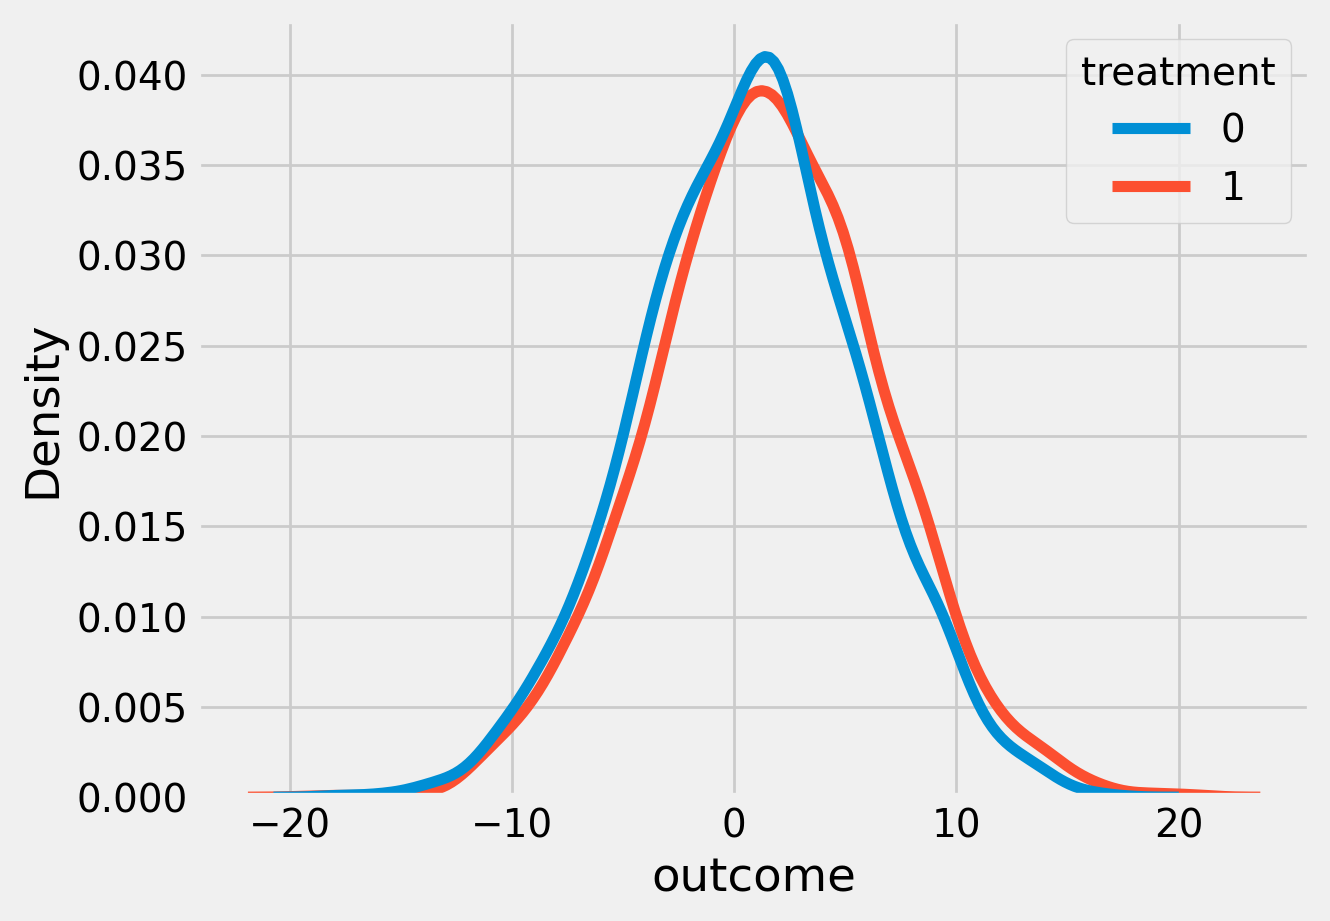

In [6]:
sns.kdeplot(data=df, x='outcome', hue='treatment')
plt.show()

In [7]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
n_test = df_test.shape[0]
n_train = df_train.shape[0]

### CausalTreeRegressor

`causal_mse`: *The criteria reward a partition for finding strong heterogeneity in treatment effects and penalize a partition that creates variance in leaf estimates.*
https://www.pnas.org/doi/10.1073/pnas.1510489113

In [8]:
# Model treatment effect

# standard_mse is an MSE criterion where nodes store treatment effects
tree1 = CausalTreeRegressor(criterion='standard_mse', 
                            control_name=0,
                            min_impurity_decrease=0,
                            min_samples_leaf=200, 
                            leaves_groups_cnt=True)
tree1.fit(X=df_train[feature_names].values,
          treatment=df_train['treatment'].values,
          y=df_train['outcome'].values
          )


tree2 = CausalTreeRegressor(criterion='causal_mse',
                            control_name=0,
                            min_samples_leaf=200, 
                            leaves_groups_cnt=True)
tree2.fit(X=df_train[feature_names].values,
          treatment=df_train['treatment'].values,
          y=df_train['outcome'].values
          )

CausalTreeRegressor(leaves_groups_cnt=True, min_samples_leaf=200)

In [9]:
tree1_ite_pred = tree1.predict(df_test[feature_names].values)
tree2_ite_pred = tree2.predict(df_test[feature_names].values)

df_result = pd.DataFrame(
    {
        'tree_mse_ite': tree1_ite_pred,
        'tree_causal_mse_ite': tree2_ite_pred,
        'outcome': df_test['outcome'],
        'is_treated': df_test['treatment'],
        'treatment_effect': df_test['treatment_effect']
    }
)
df_result = df_result.reset_index(drop=True)
df_result.head()

tree_mse_ite  tree_causal_mse_ite    outcome  is_treated  treatment_effect
0      1.564334             2.053674  -6.226016           0          2.434805
1      0.697023            -0.635854   0.722683           0          0.359669
2      0.451700            -2.538588   6.190585           1          0.031169
3      0.619100            -0.272882  -2.054093           0          1.780163
4      0.827492             0.260810  13.723378           1          1.352523

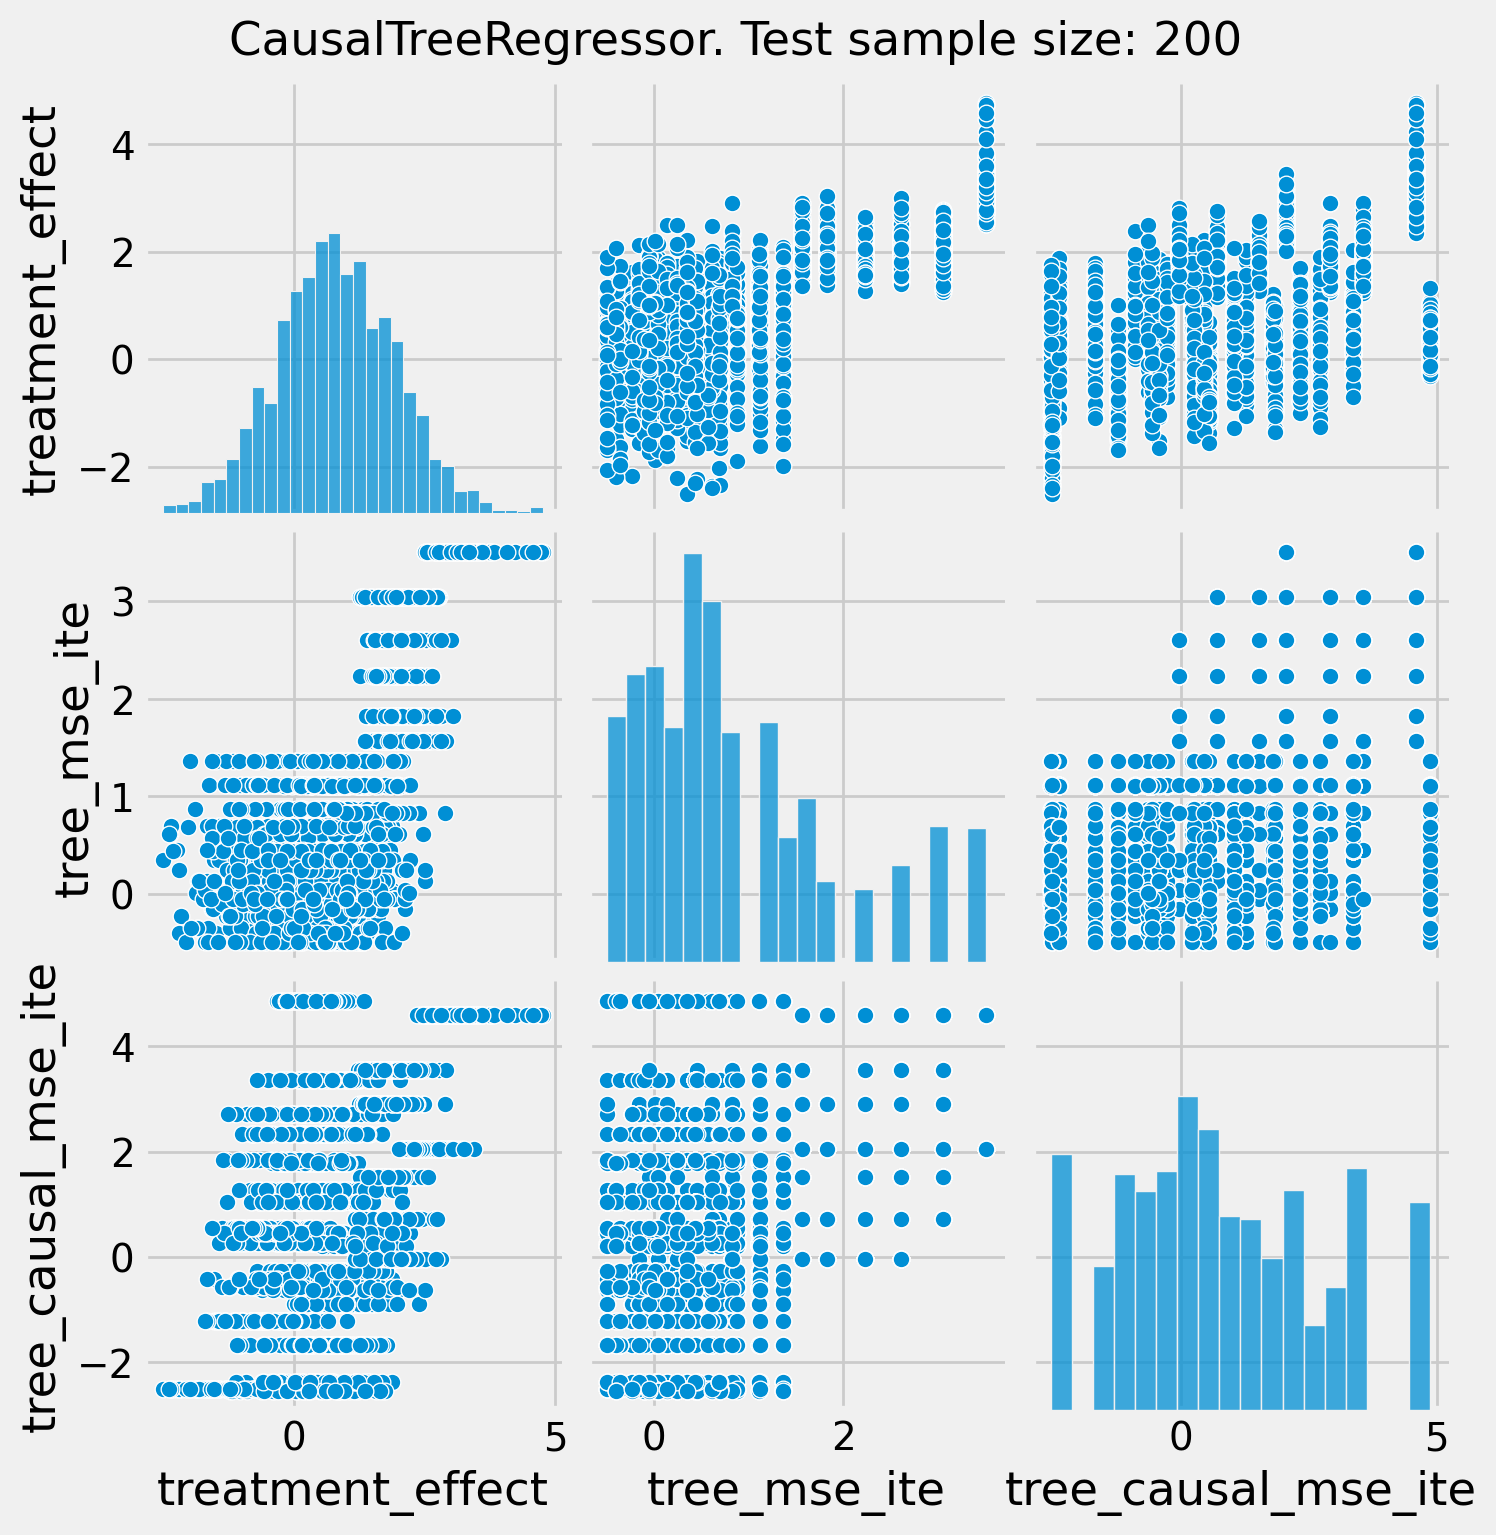

In [10]:
# See treatment effect estimation with CausalTreeRegressor vs true treatment effect

n_obs = 200

indxs = df_result.index.values
np.random.shuffle(indxs)
indxs = indxs[:n_obs]

pairplot = sns.pairplot(df_result[['treatment_effect', 'tree_mse_ite', 'tree_causal_mse_ite']])
pairplot.fig.suptitle(f"CausalTreeRegressor. Test sample size: {n_obs}" , y=1.02)
plt.show()

#### Plot the Qini chart

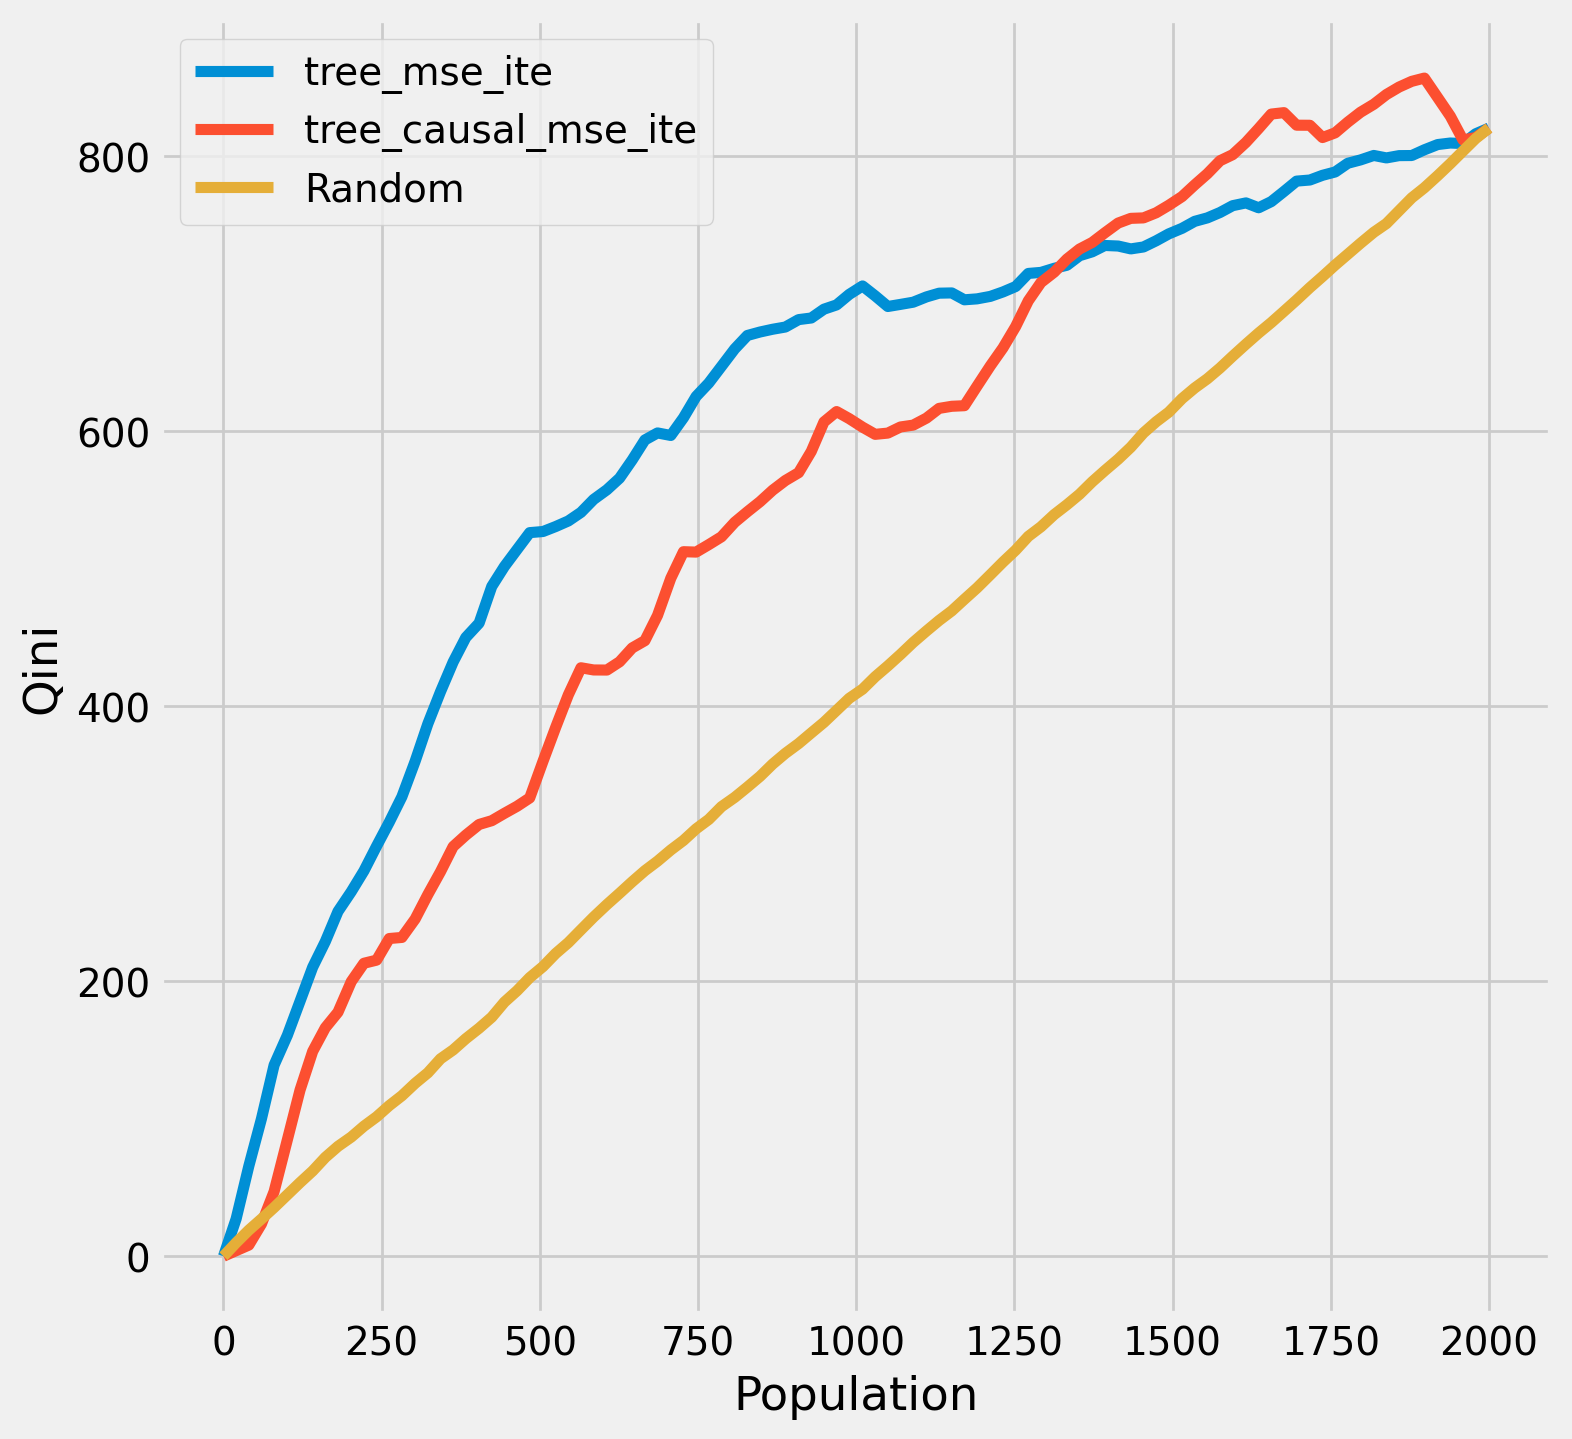

In [11]:
stat_columns = ['treatment_effect', 'is_treated', 'outcome',
                'tree_mse_ite', 'tree_causal_mse_ite'
               ]
plot_qini(df_result[stat_columns],
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
         )

In [12]:
df_qini = qini_score(df_result[stat_columns],
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')
df_qini.sort_values(ascending=False)

tree_mse_ite           0.236528
tree_causal_mse_ite    0.168610
Random                 0.000000
dtype: float64

#### The cumulative gain of the true treatment effect in each population

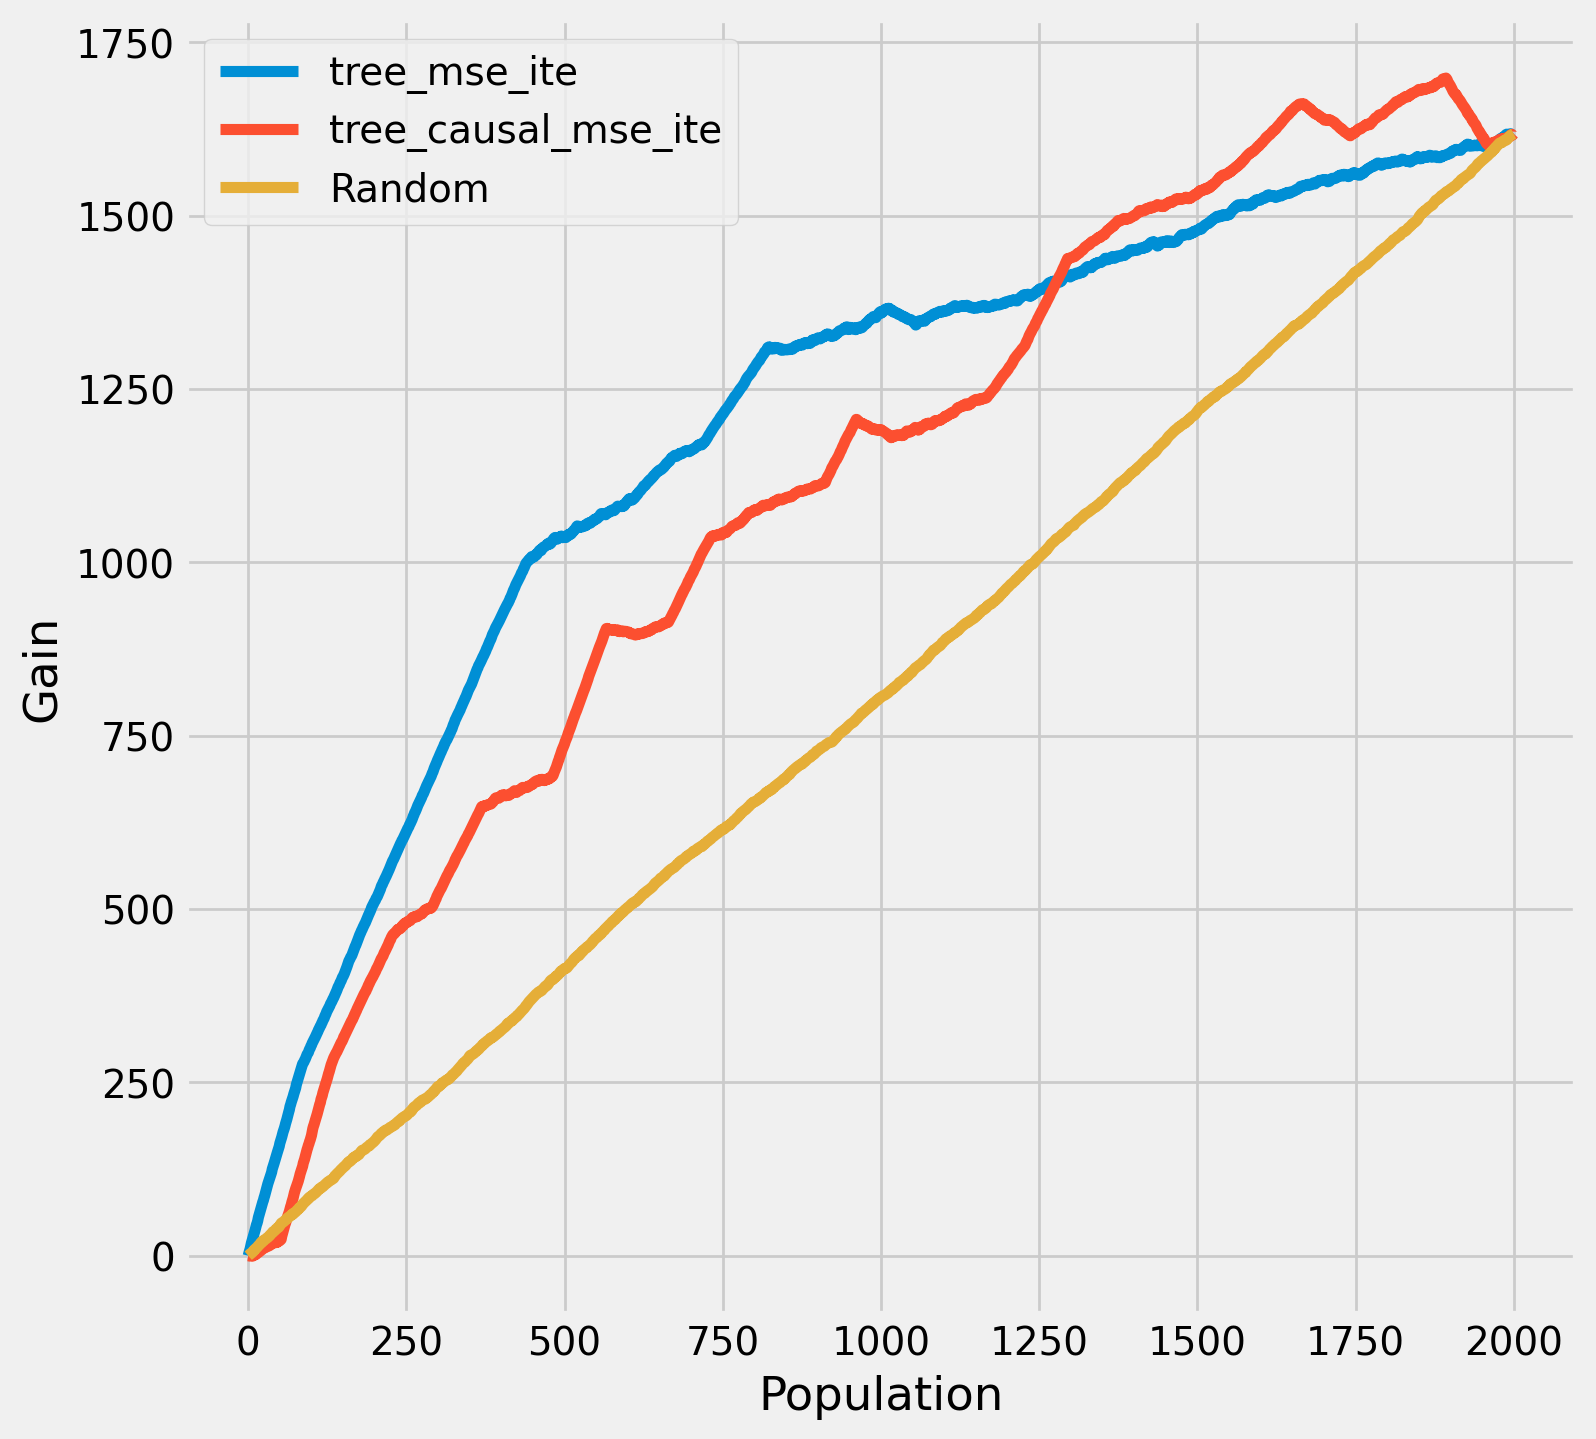

In [13]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          n = n_test
         )

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

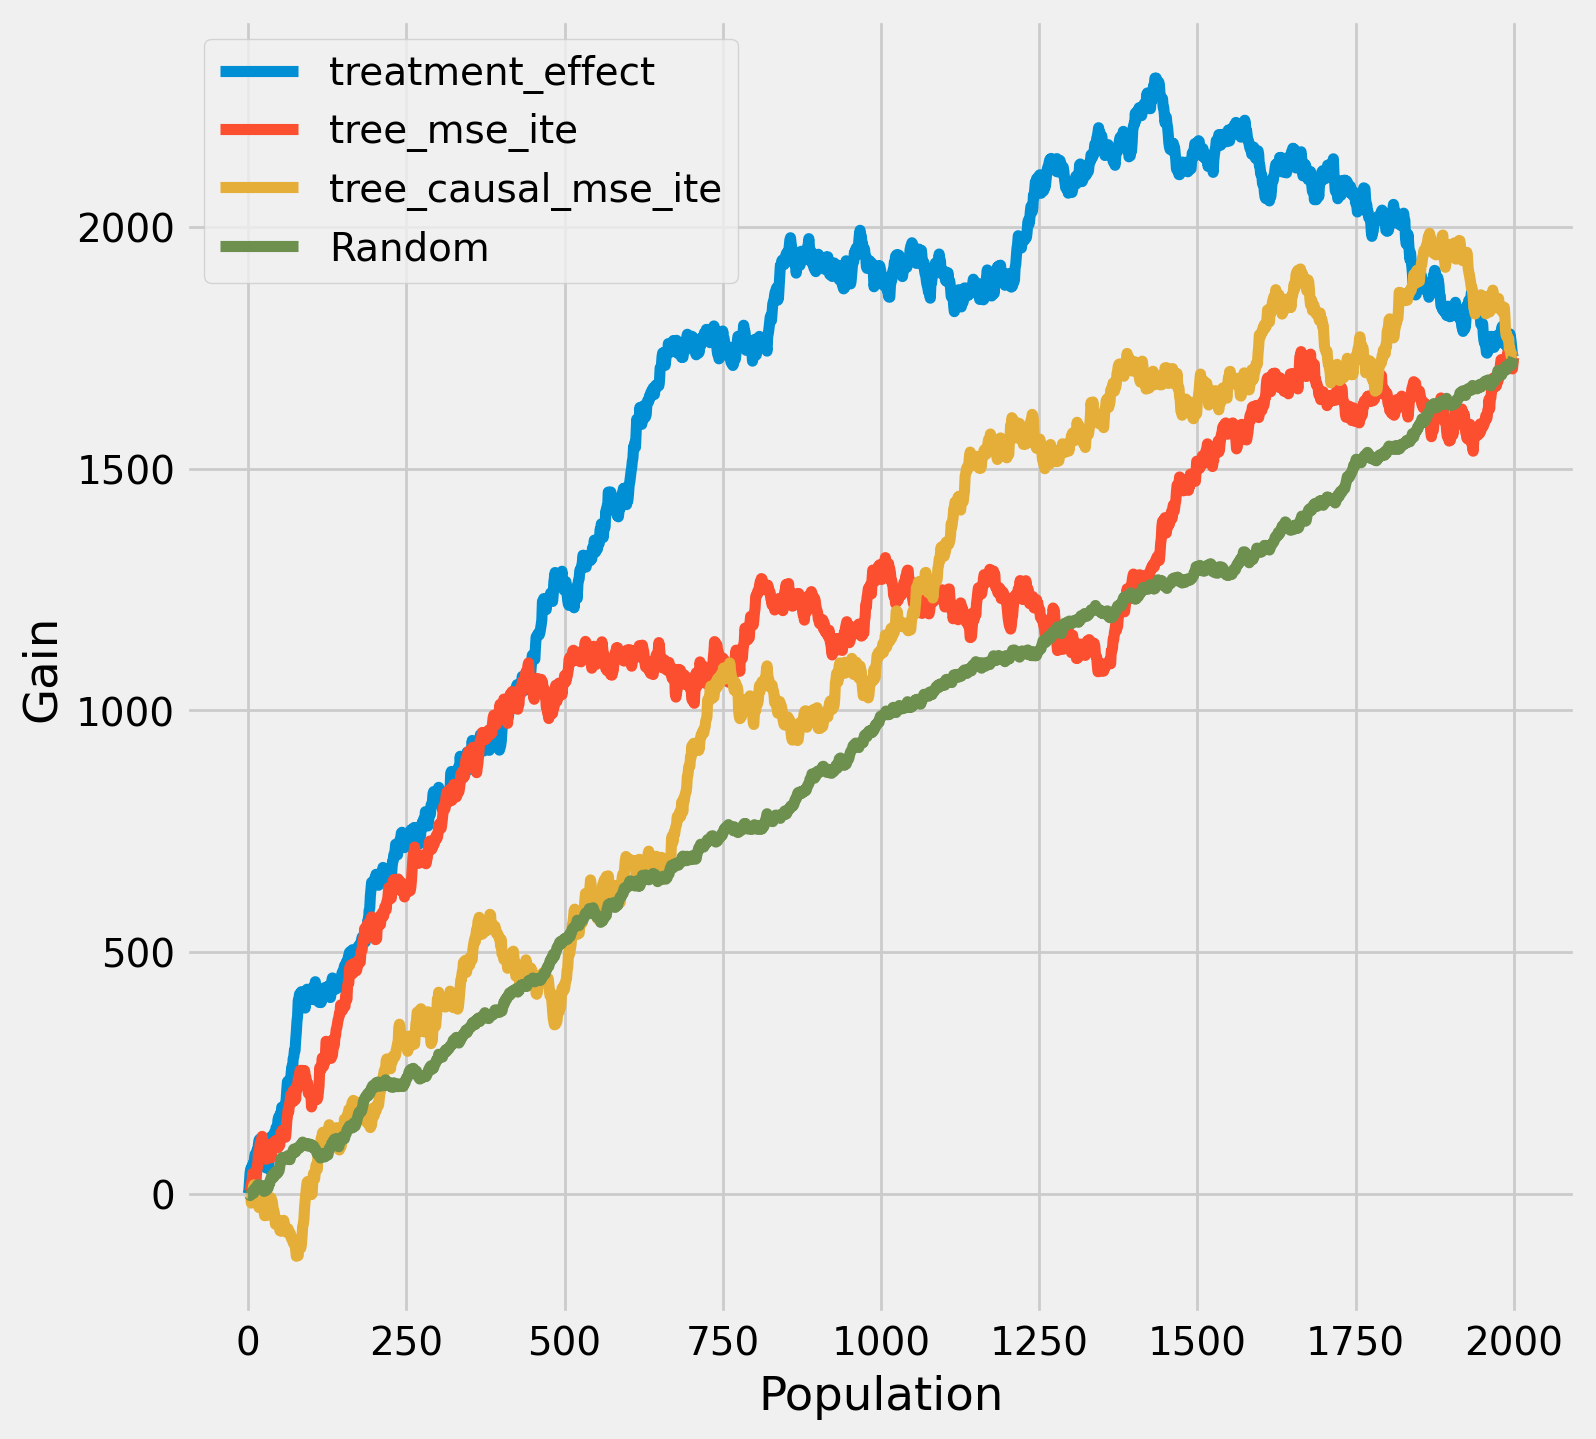

In [14]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test
         )

#### Plot trees with sklearn function and save as vector graphics

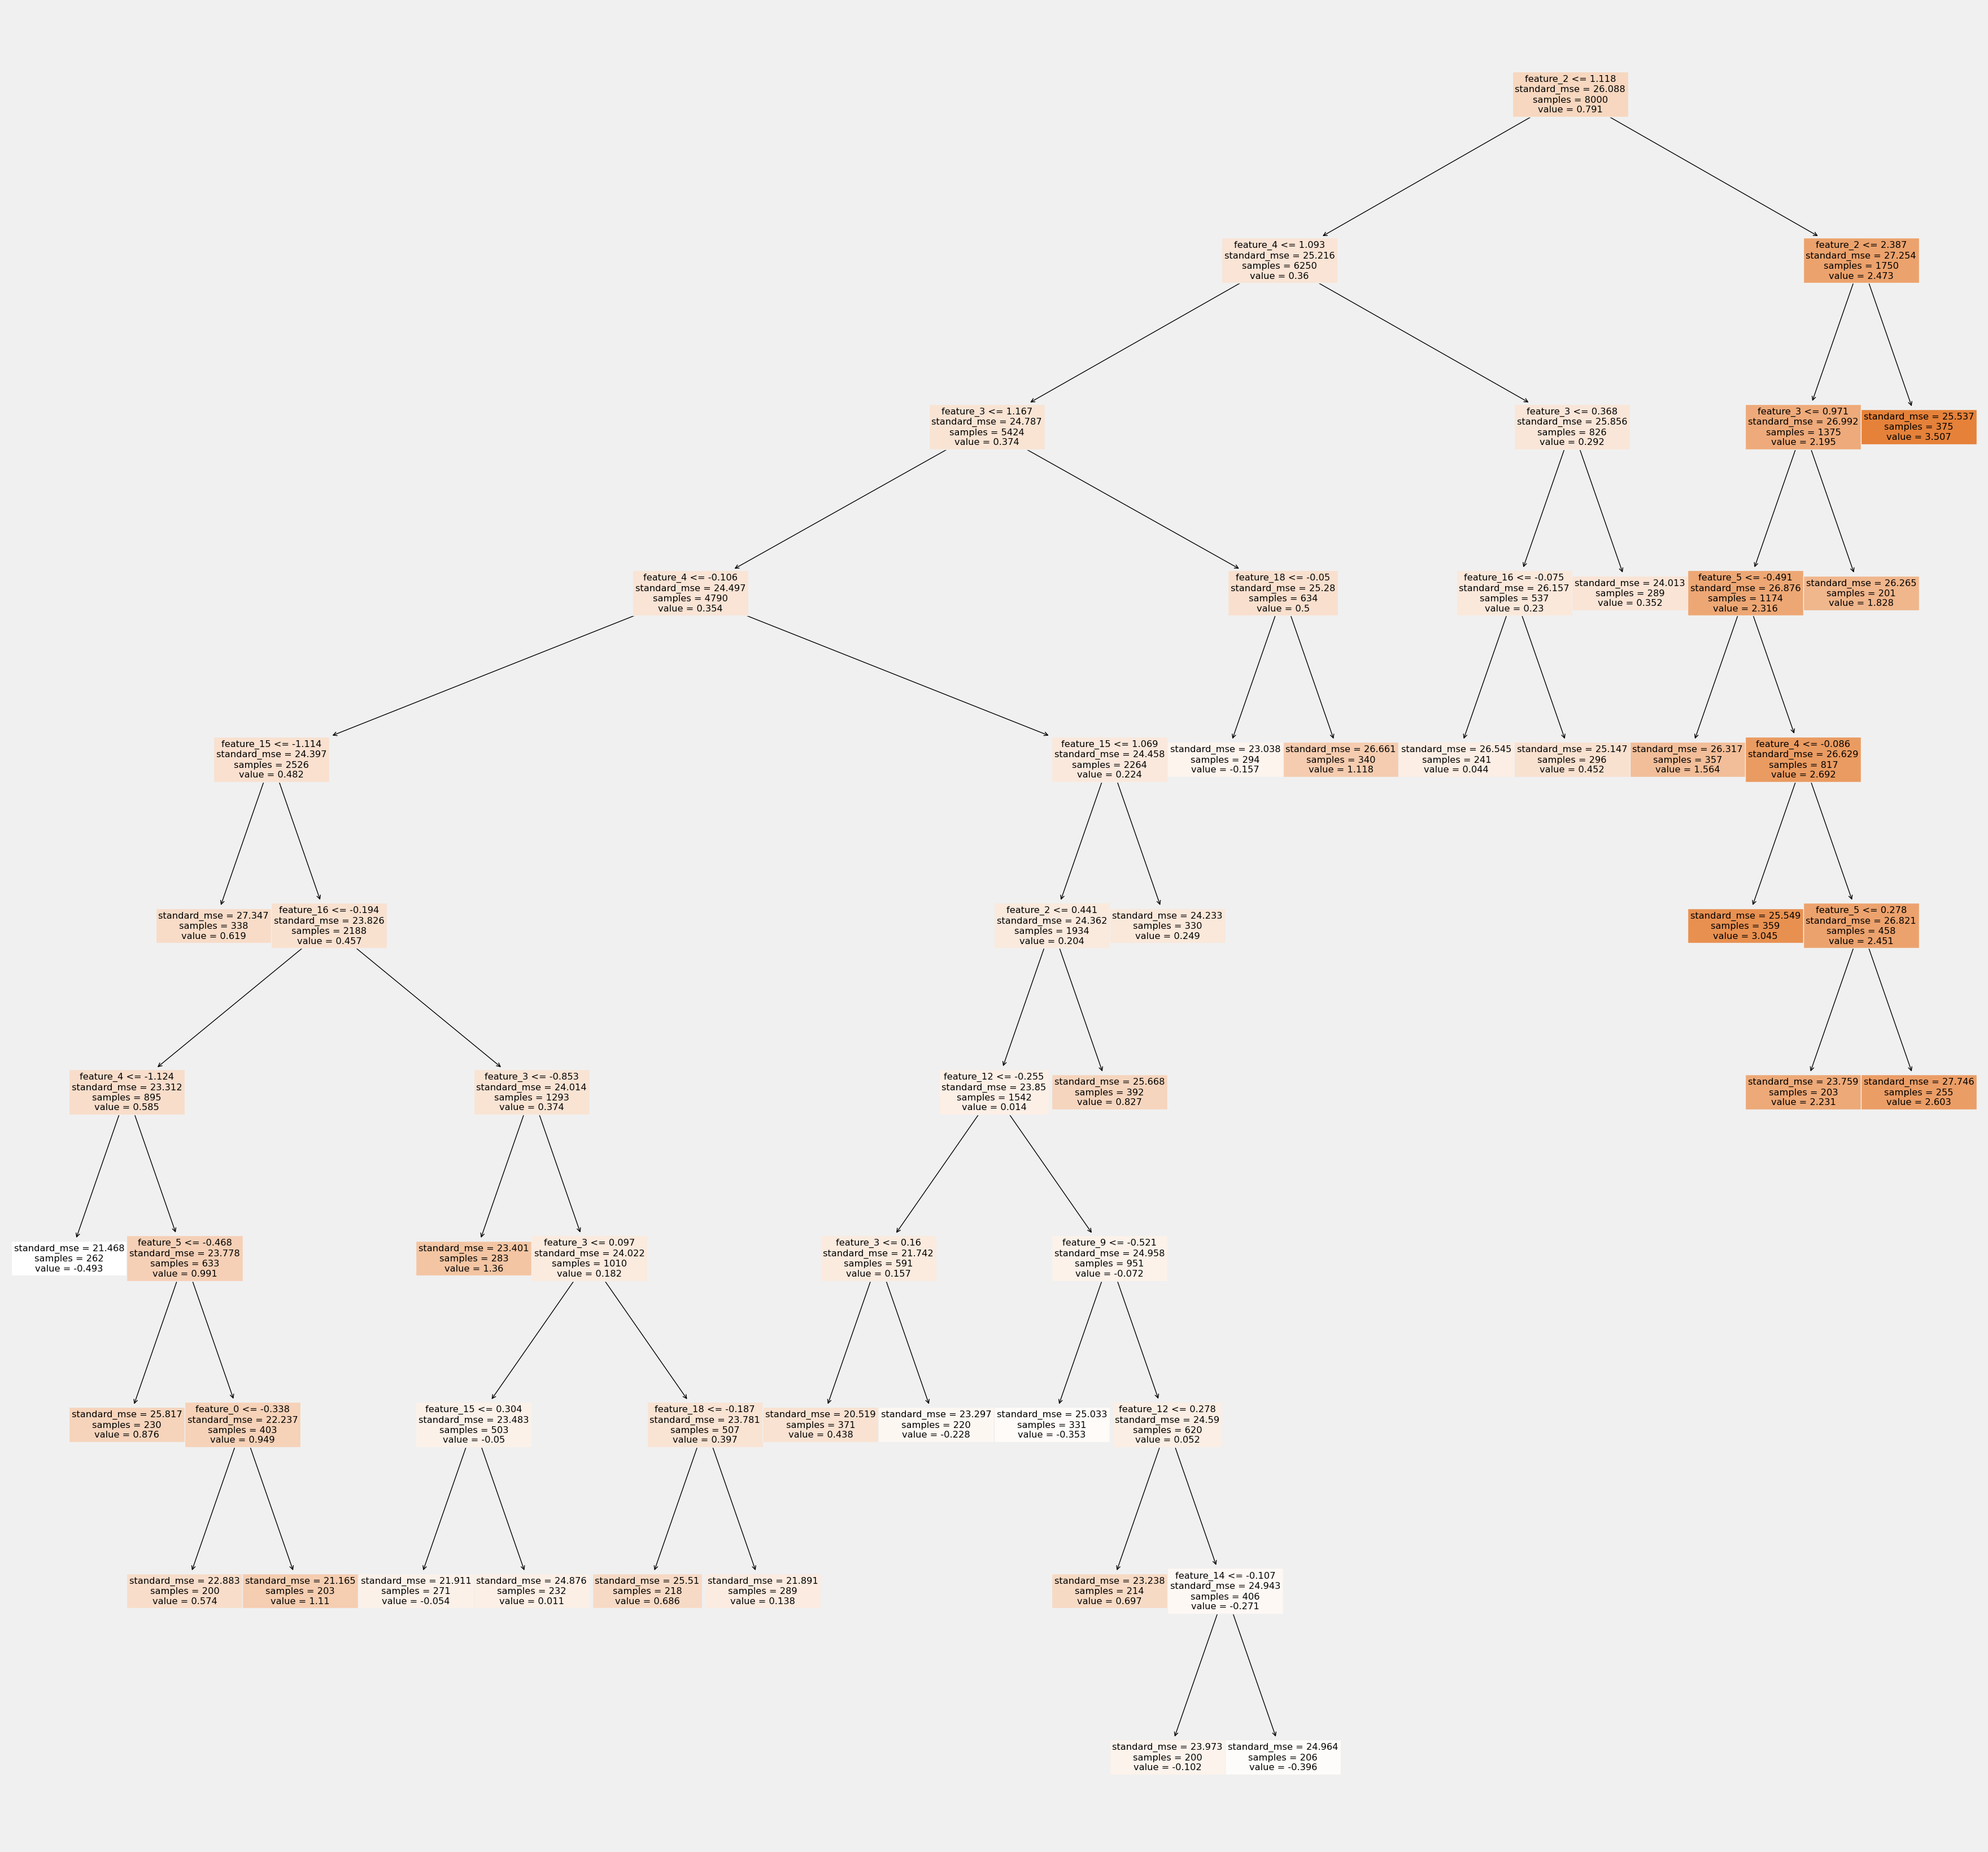

In [15]:
plt.figure(figsize=(20,20))
plot_tree(tree1, 
          feature_names = feature_names,
          filled=True,
          impurity=True,
          proportion=False,
          )
plt.savefig('tree_mse.svg')

In [16]:
tree1.tree_.n_leaves

29

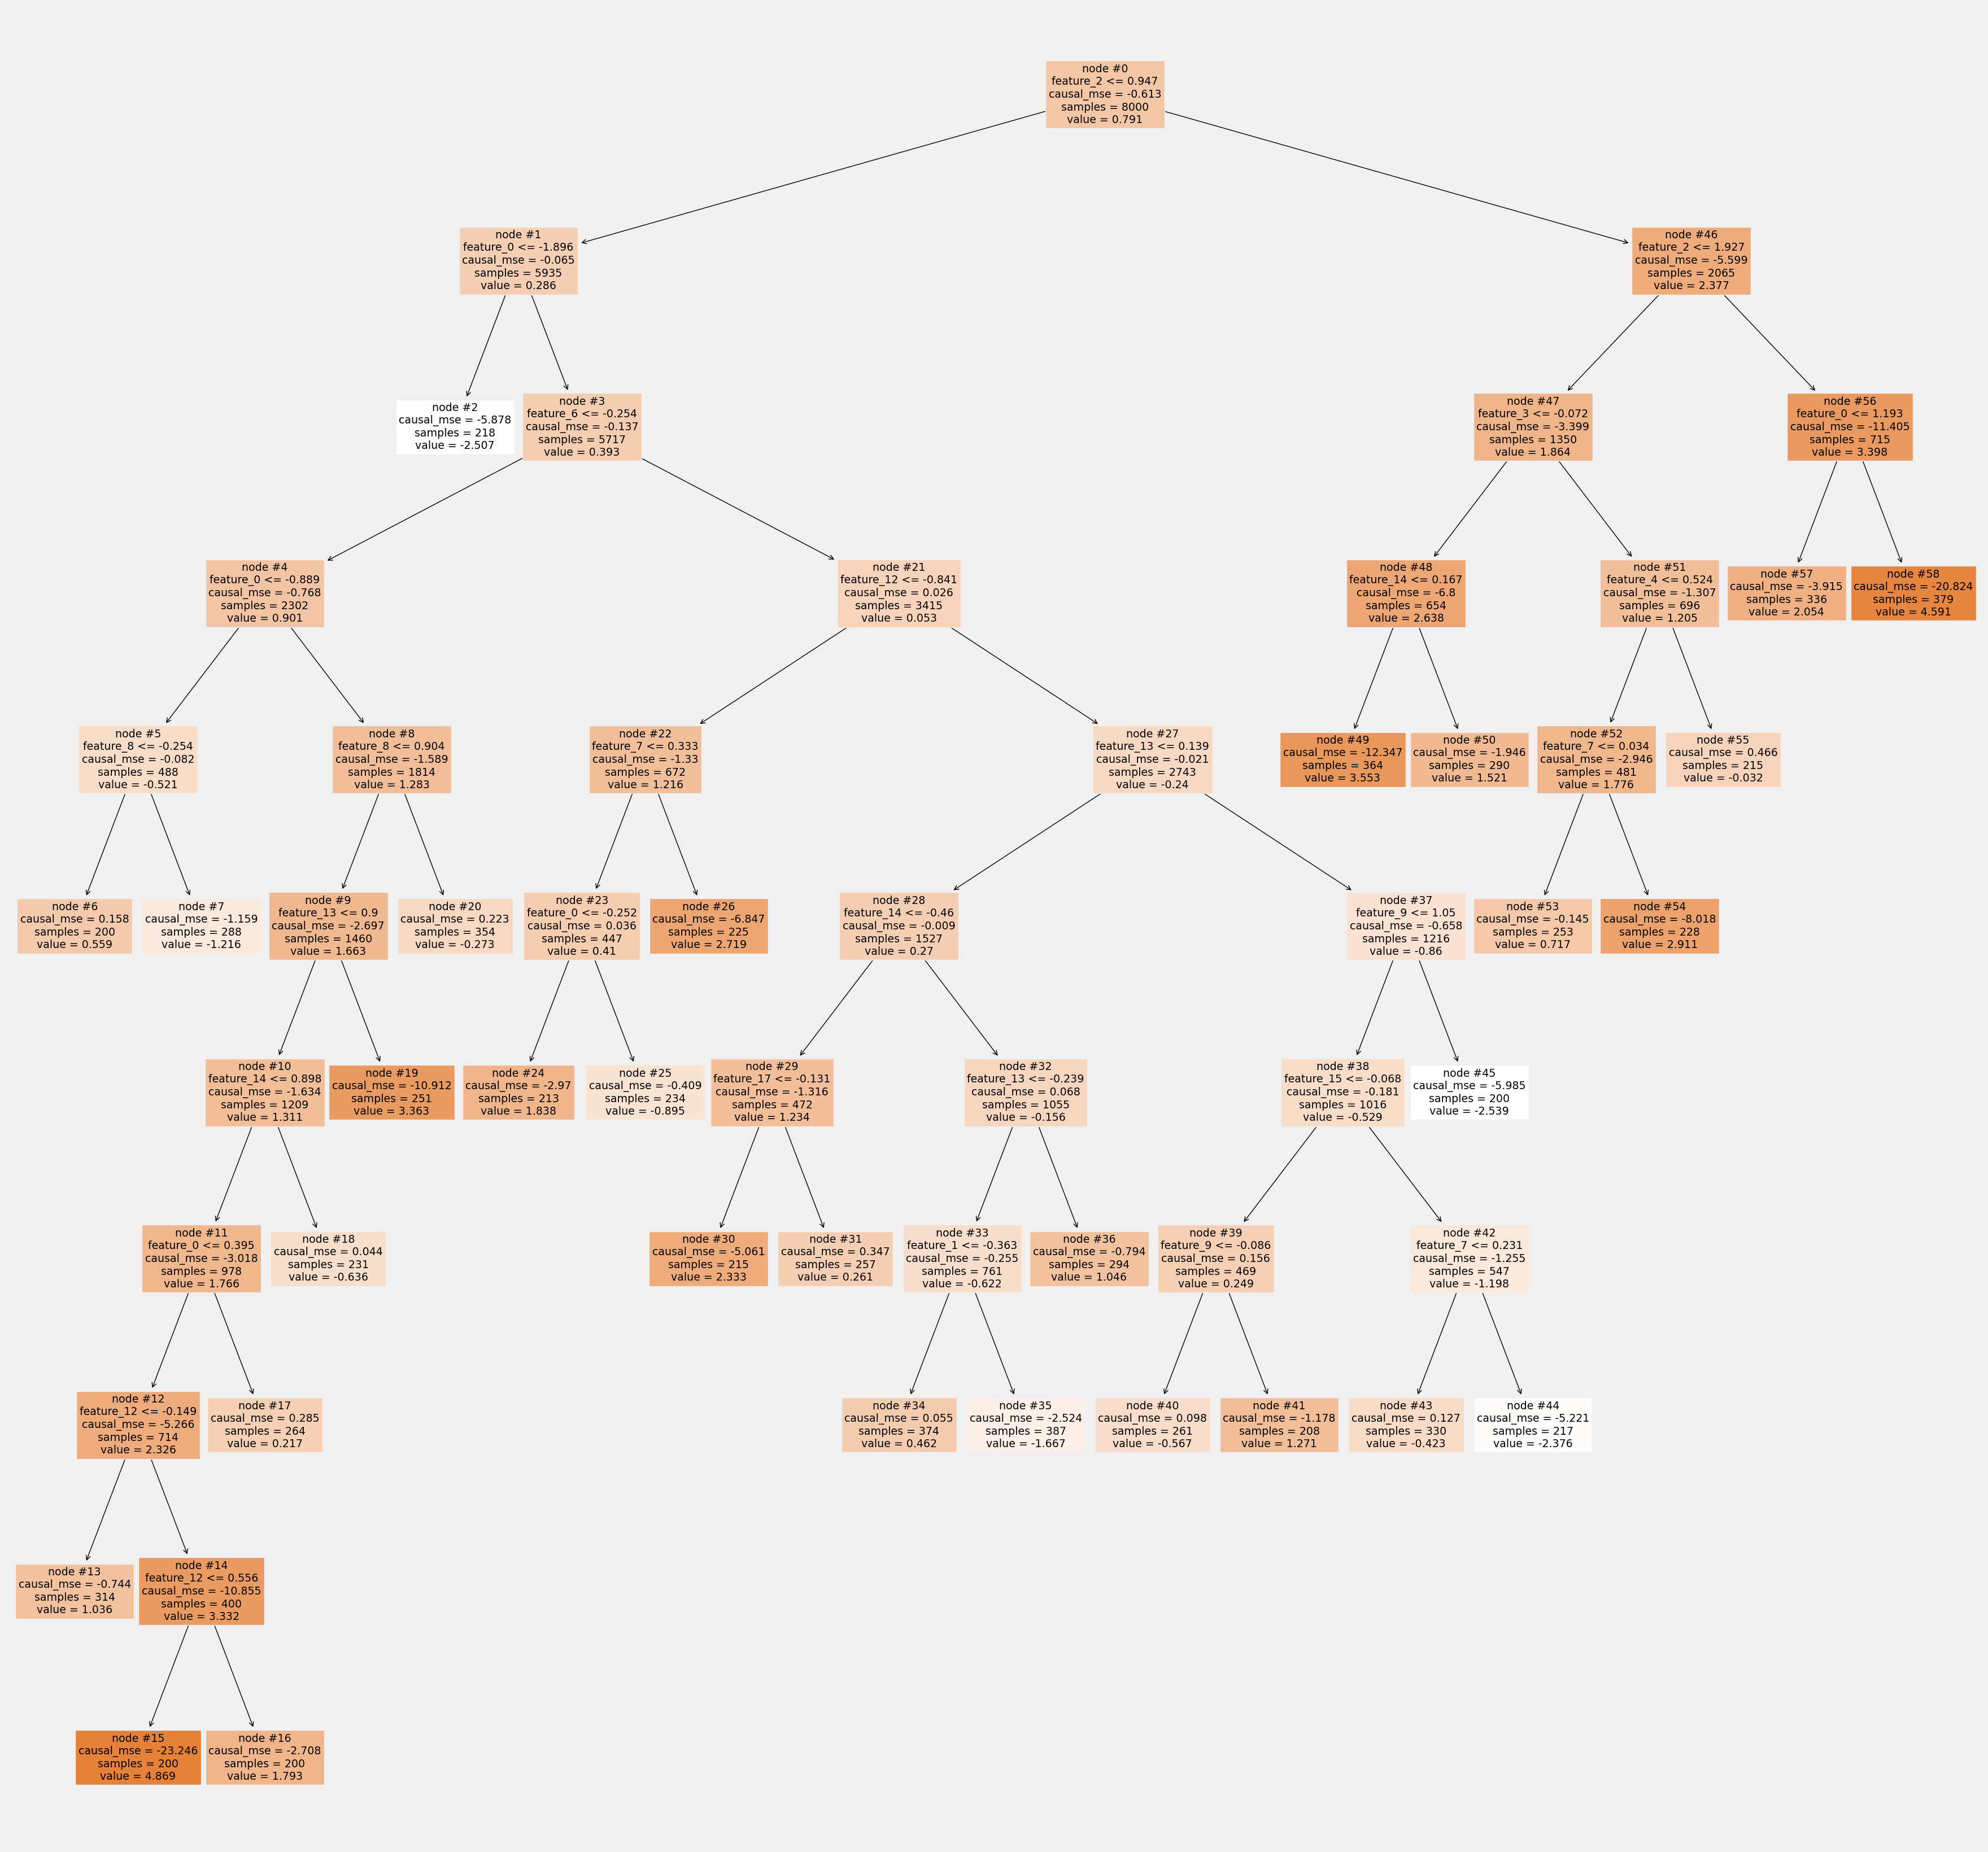

In [17]:
plt.figure(figsize=(20,20))
plot_tree(tree2, 
          feature_names = feature_names,
          filled=True,
          impurity=True,
          proportion=False,
          node_ids=True,
         )
plt.savefig('tree_causal_mse.svg')

#### How values in leaves of the fitted trees differ from each other:

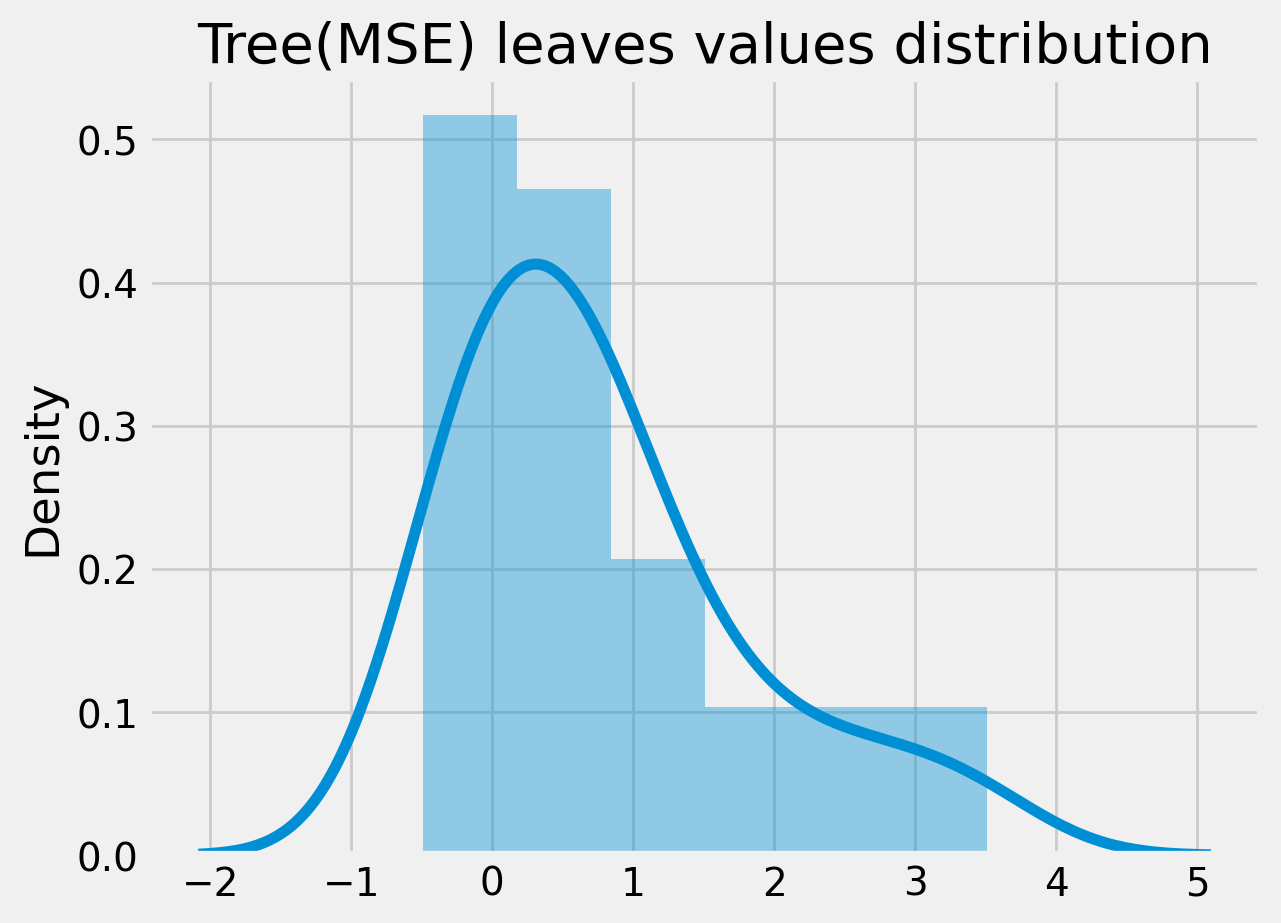

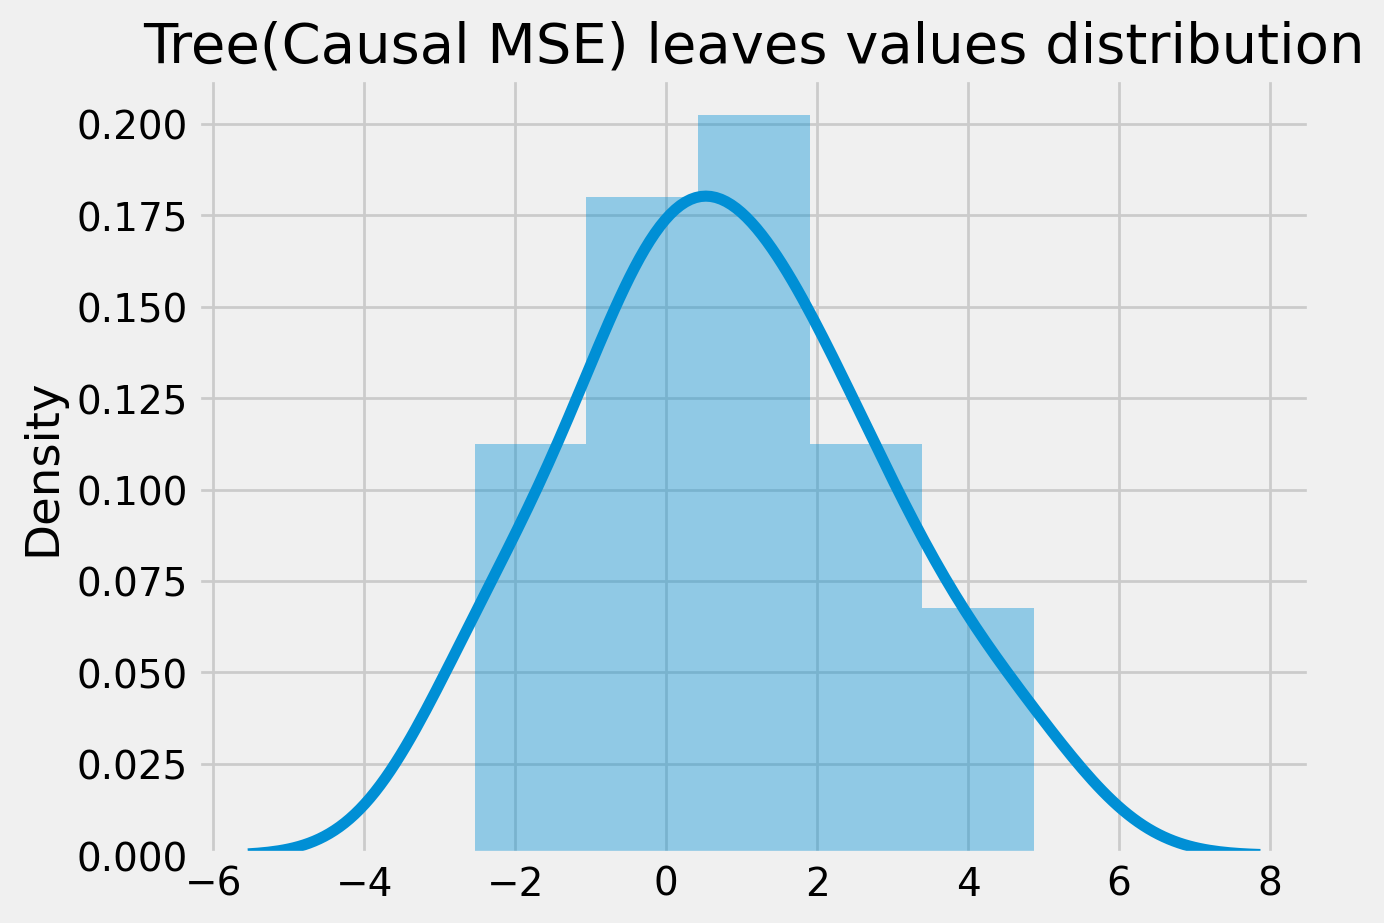

In [18]:
plot_dist_tree_leaves_values(tree1, title='Tree(MSE) leaves values distribution')
plot_dist_tree_leaves_values(tree2, title='Tree(Causal MSE) leaves values distribution')

In [19]:
# Treatment groups distribution in tree leaves
tree2._leaves_groups_cnt

{2: {0: 106, 1: 112},
 6: {0: 88, 1: 112},
 7: {0: 150, 1: 138},
 13: {0: 156, 1: 158},
 15: {0: 97, 1: 103},
 16: {0: 96, 1: 104},
 17: {0: 120, 1: 144},
 18: {0: 109, 1: 122},
 19: {0: 120, 1: 131},
 20: {0: 173, 1: 181},
 24: {0: 109, 1: 104},
 25: {0: 111, 1: 123},
 26: {0: 132, 1: 93},
 30: {0: 109, 1: 106},
 31: {0: 124, 1: 133},
 34: {0: 188, 1: 186},
 35: {0: 201, 1: 186},
 36: {0: 146, 1: 148},
 40: {0: 136, 1: 125},
 41: {0: 95, 1: 113},
 43: {0: 155, 1: 175},
 44: {0: 102, 1: 115},
 45: {0: 94, 1: 106},
 49: {0: 171, 1: 193},
 50: {0: 151, 1: 139},
 53: {0: 143, 1: 110},
 54: {0: 112, 1: 116},
 55: {0: 121, 1: 94},
 57: {0: 177, 1: 159},
 58: {0: 203, 1: 176}}

### CausalRandomForestRegressor 

In [20]:
# Model treatment effect

# standard_mse is an MSE criterion where nodes store treatment effects
rforest1 = CausalRandomForestRegressor(criterion="standard_mse",
                                       min_samples_leaf=200,
                                       min_impurity_decrease=0.0,
                                       control_name=0, n_estimators=50, n_jobs=4)
rforest1.fit(X=df_train[feature_names].values,
             treatment=df_train['treatment'].values,
             y=df_train['outcome'].values
             )


rforest2 = CausalRandomForestRegressor(criterion="causal_mse",
                                       min_samples_leaf=200,
                                       control_name=0,
                                       n_estimators=50,
                                       n_jobs=4)
rforest2.fit(X=df_train[feature_names].values,
             treatment=df_train['treatment'].values,
             y=df_train['outcome'].values
             )

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=50, n_jobs=4)

In [21]:
rf1_ite_pred = rforest1.predict(df_test[feature_names].values)
rf2_ite_pred = rforest2.predict(df_test[feature_names].values)

df_result['rforest_mse_ite'] = rf1_ite_pred
df_result['rforest_causal_mse_ite'] = rf2_ite_pred
df_result.head()

tree_mse_ite  tree_causal_mse_ite    outcome  is_treated  treatment_effect  \
0      1.564334             2.053674  -6.226016           0          2.434805   
1      0.697023            -0.635854   0.722683           0          0.359669   
2      0.451700            -2.538588   6.190585           1          0.031169   
3      0.619100            -0.272882  -2.054093           0          1.780163   
4      0.827492             0.260810  13.723378           1          1.352523   

   rforest_mse_ite  rforest_causal_mse_ite  
0         1.599689                2.407300  
1         0.996063               -0.441109  
2         0.294540               -0.539287  
3         0.651409                2.060295  
4         0.786262                1.004714

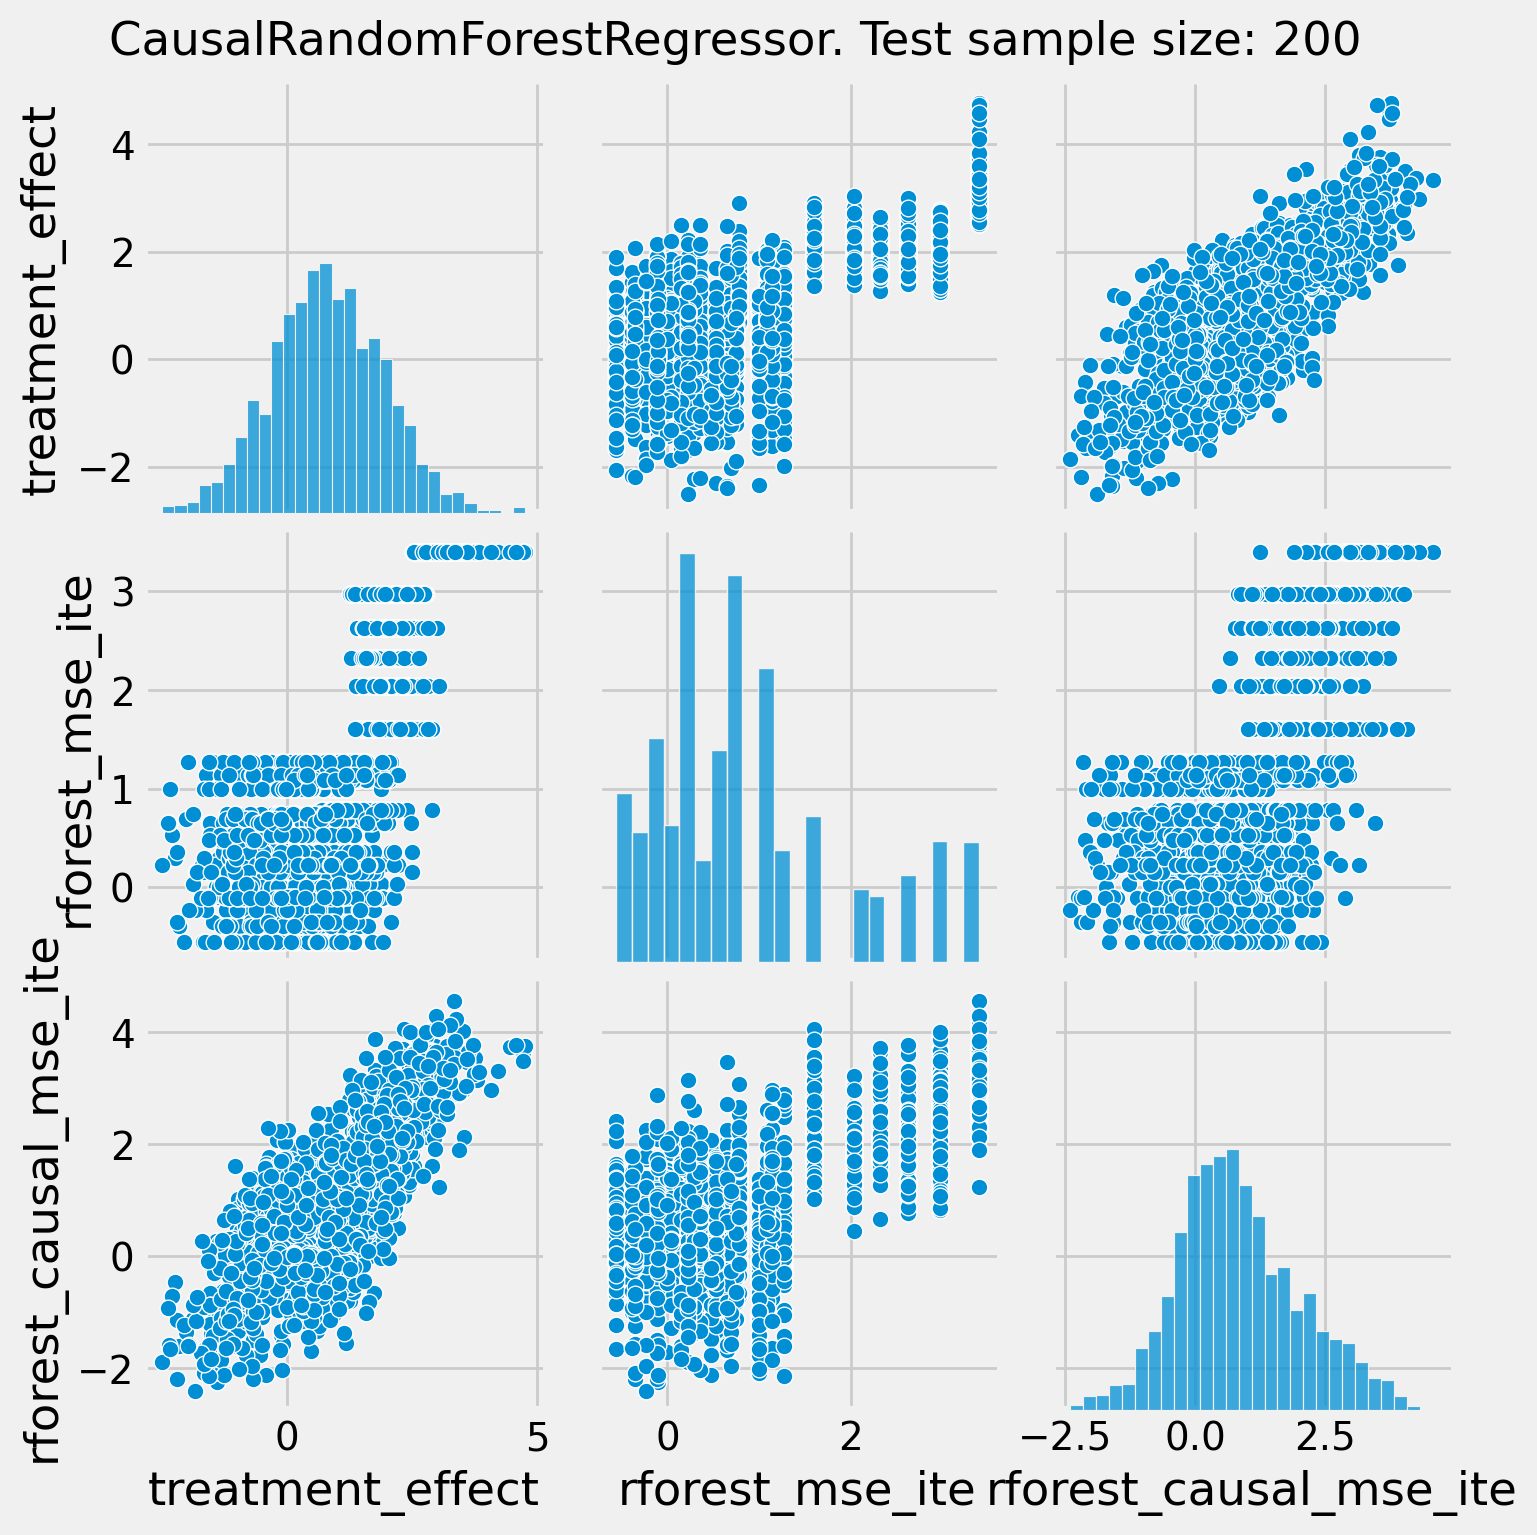

In [22]:
# See treatment effect estimation with CausalRandomForestRegressor vs true treatment effect 

n_obs = 200

indxs = df_result.index.values
np.random.shuffle(indxs)
indxs = indxs[:n_obs]

pairplot = sns.pairplot(df_result[['treatment_effect', 'rforest_mse_ite', 'rforest_causal_mse_ite']])
pairplot.fig.suptitle(f"CausalRandomForestRegressor. Test sample size: {n_obs}" , y=1.02)
plt.show()

In [23]:
stat_columns.extend(['rforest_mse_ite', 'rforest_causal_mse_ite'])

#### Qini chart

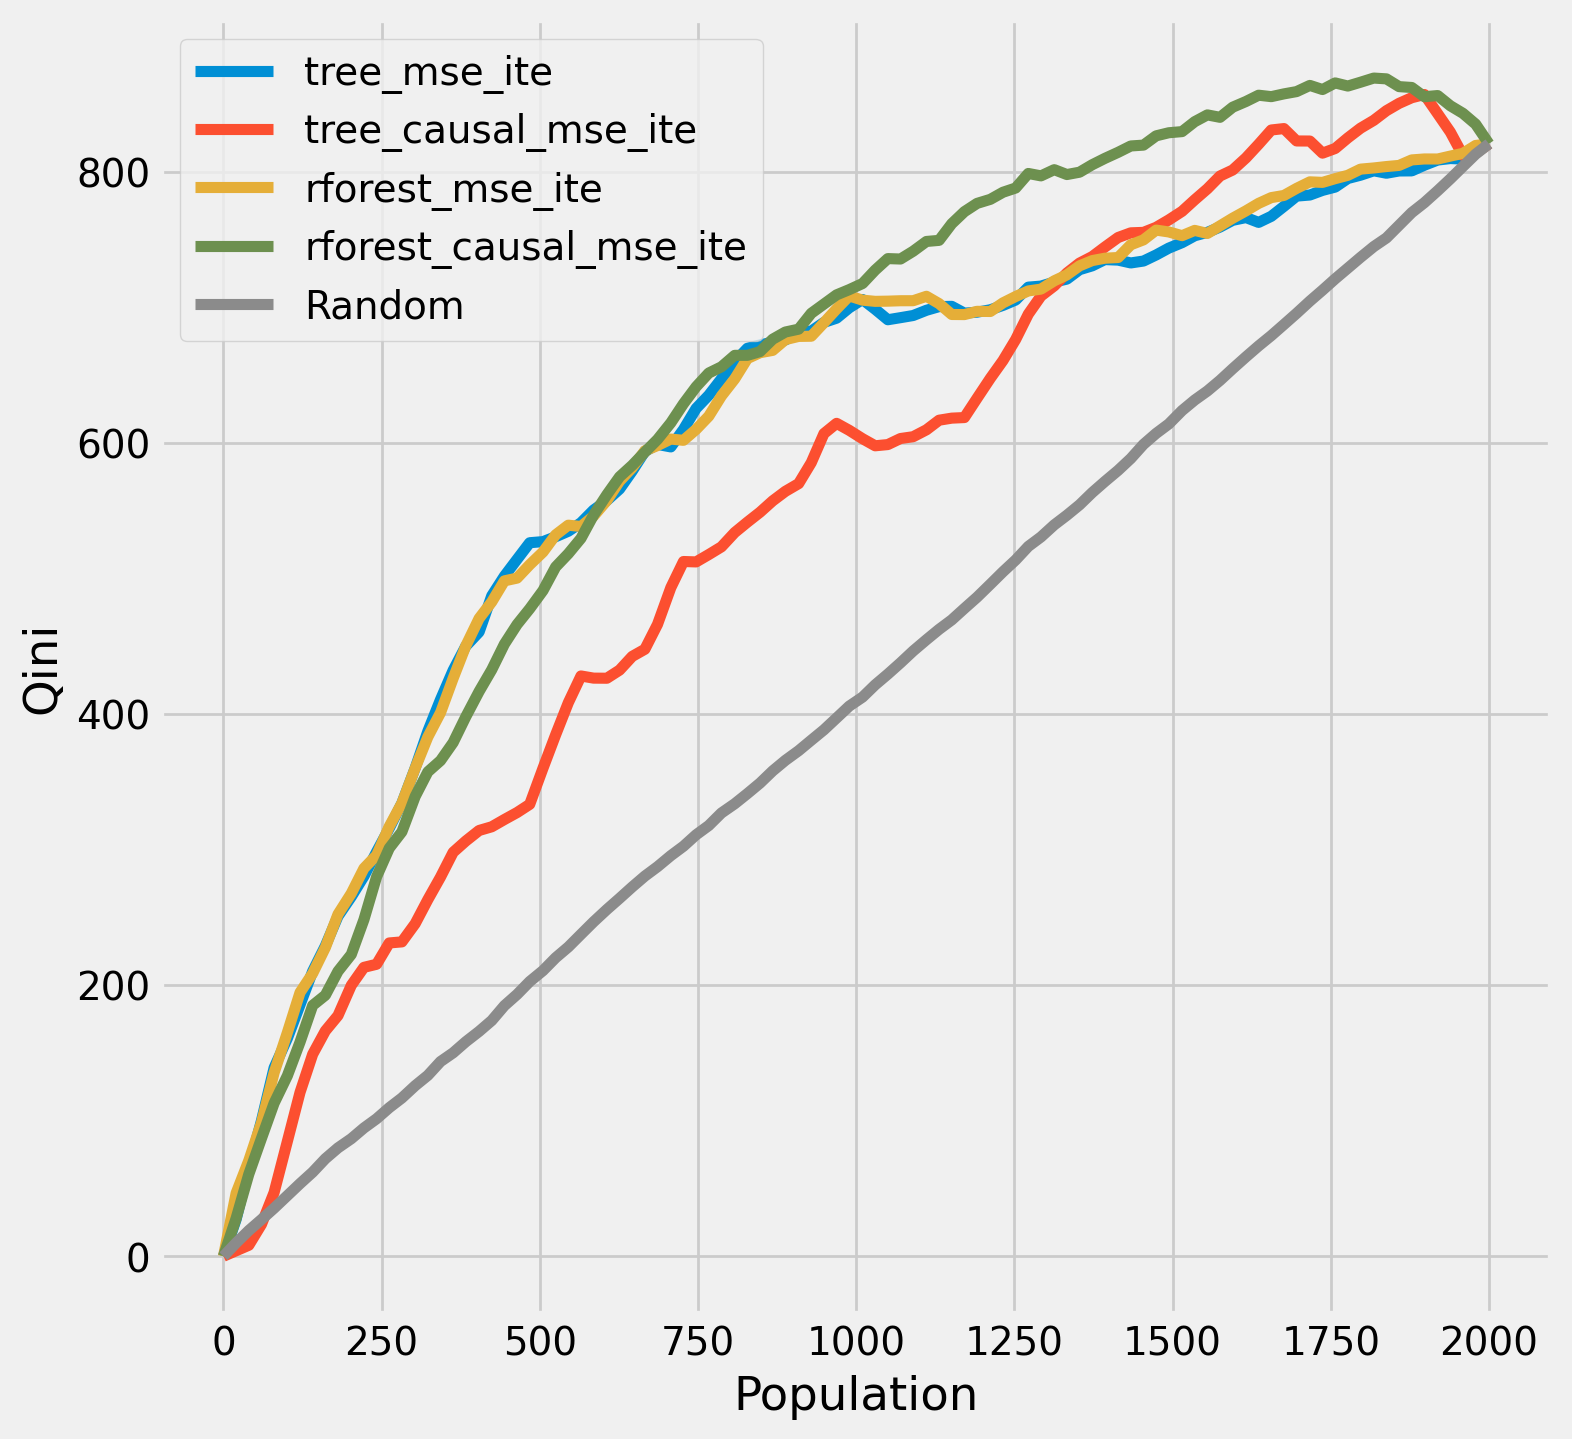

In [24]:
plot_qini(df_result[stat_columns],
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
         )

In [25]:
df_qini = qini_score(df_result[stat_columns],
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')

df_qini.sort_values(ascending=False)

rforest_causal_mse_ite    0.269309
rforest_mse_ite           0.238682
tree_mse_ite              0.236528
tree_causal_mse_ite       0.168610
Random                    0.000000
dtype: float64

#### The cumulative gain of the true treatment effect in each population

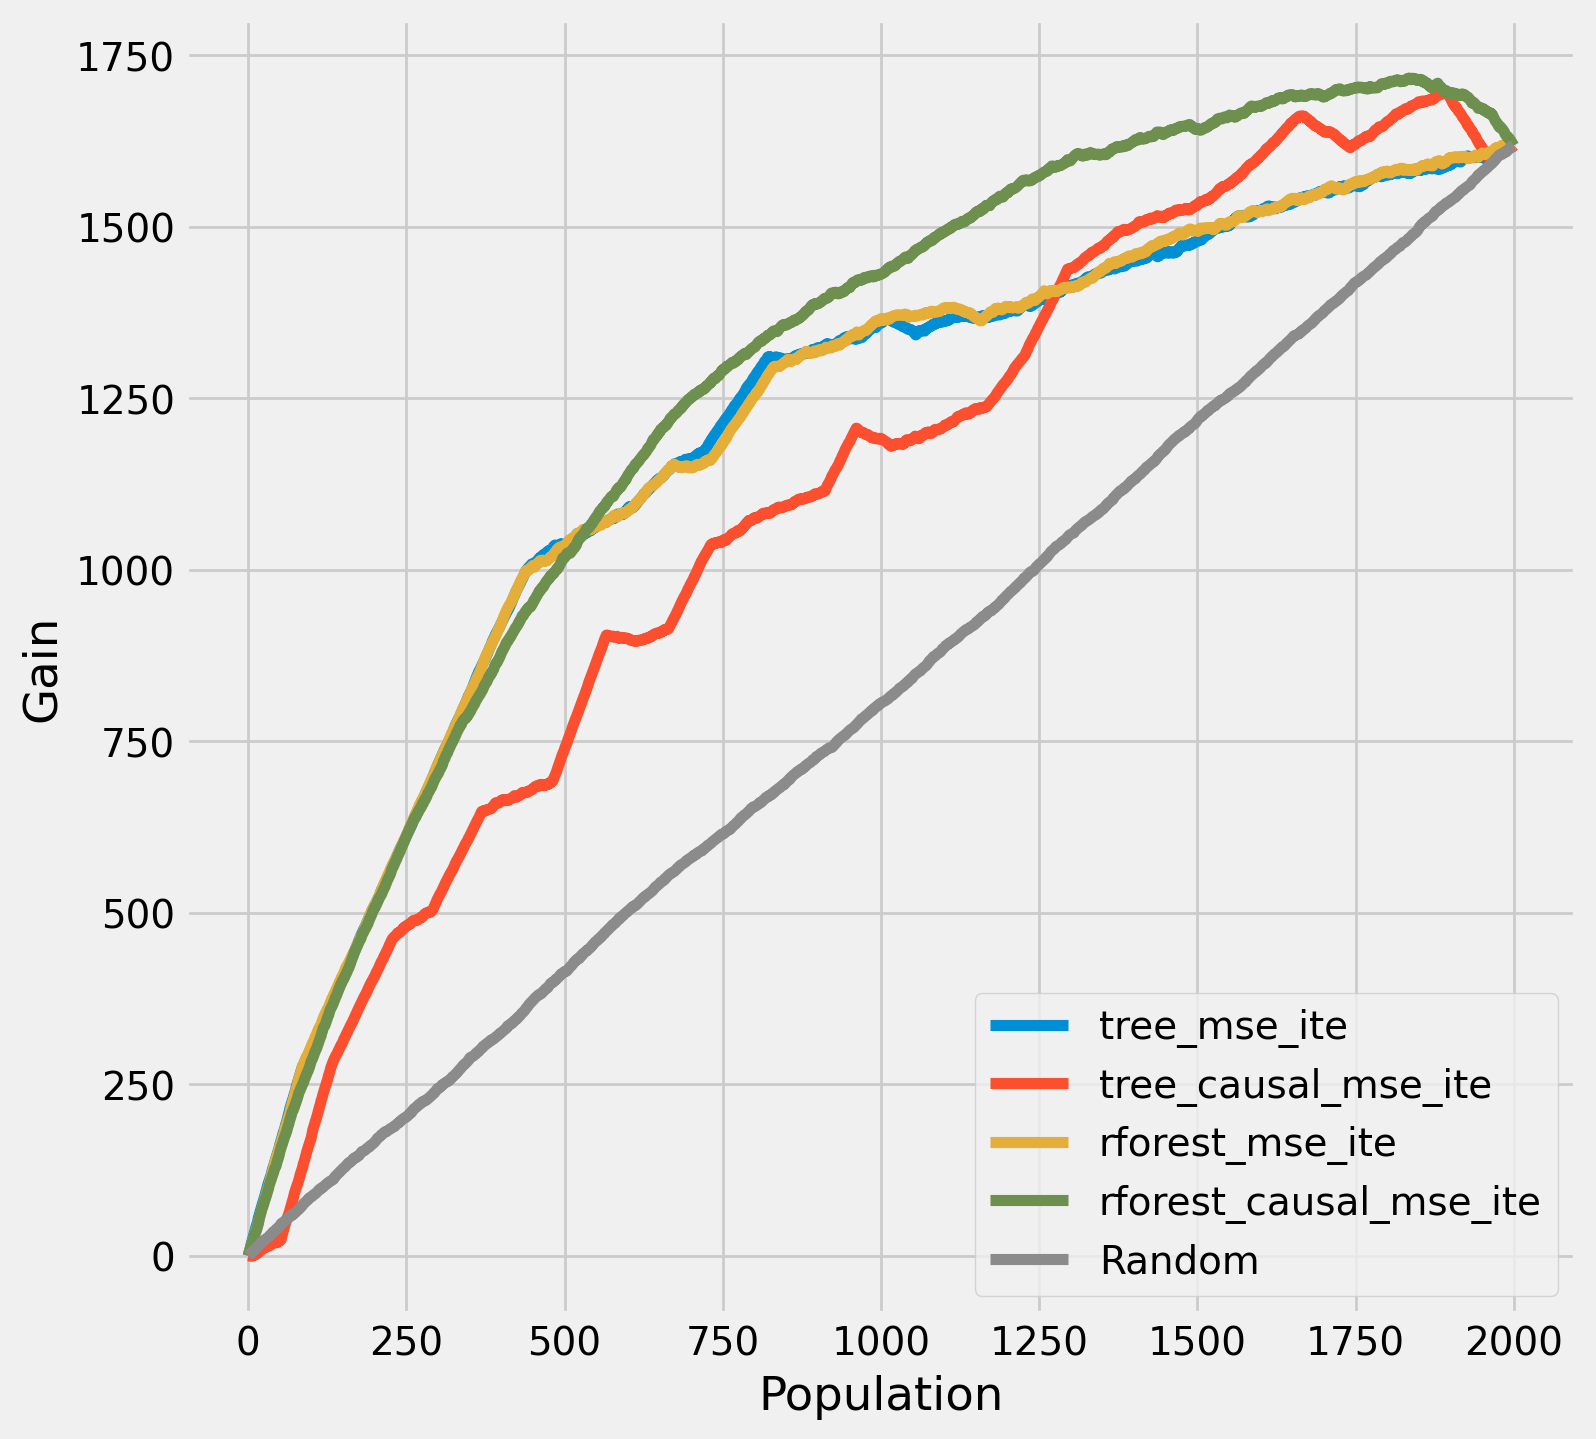

In [26]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          n = n_test
         )

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

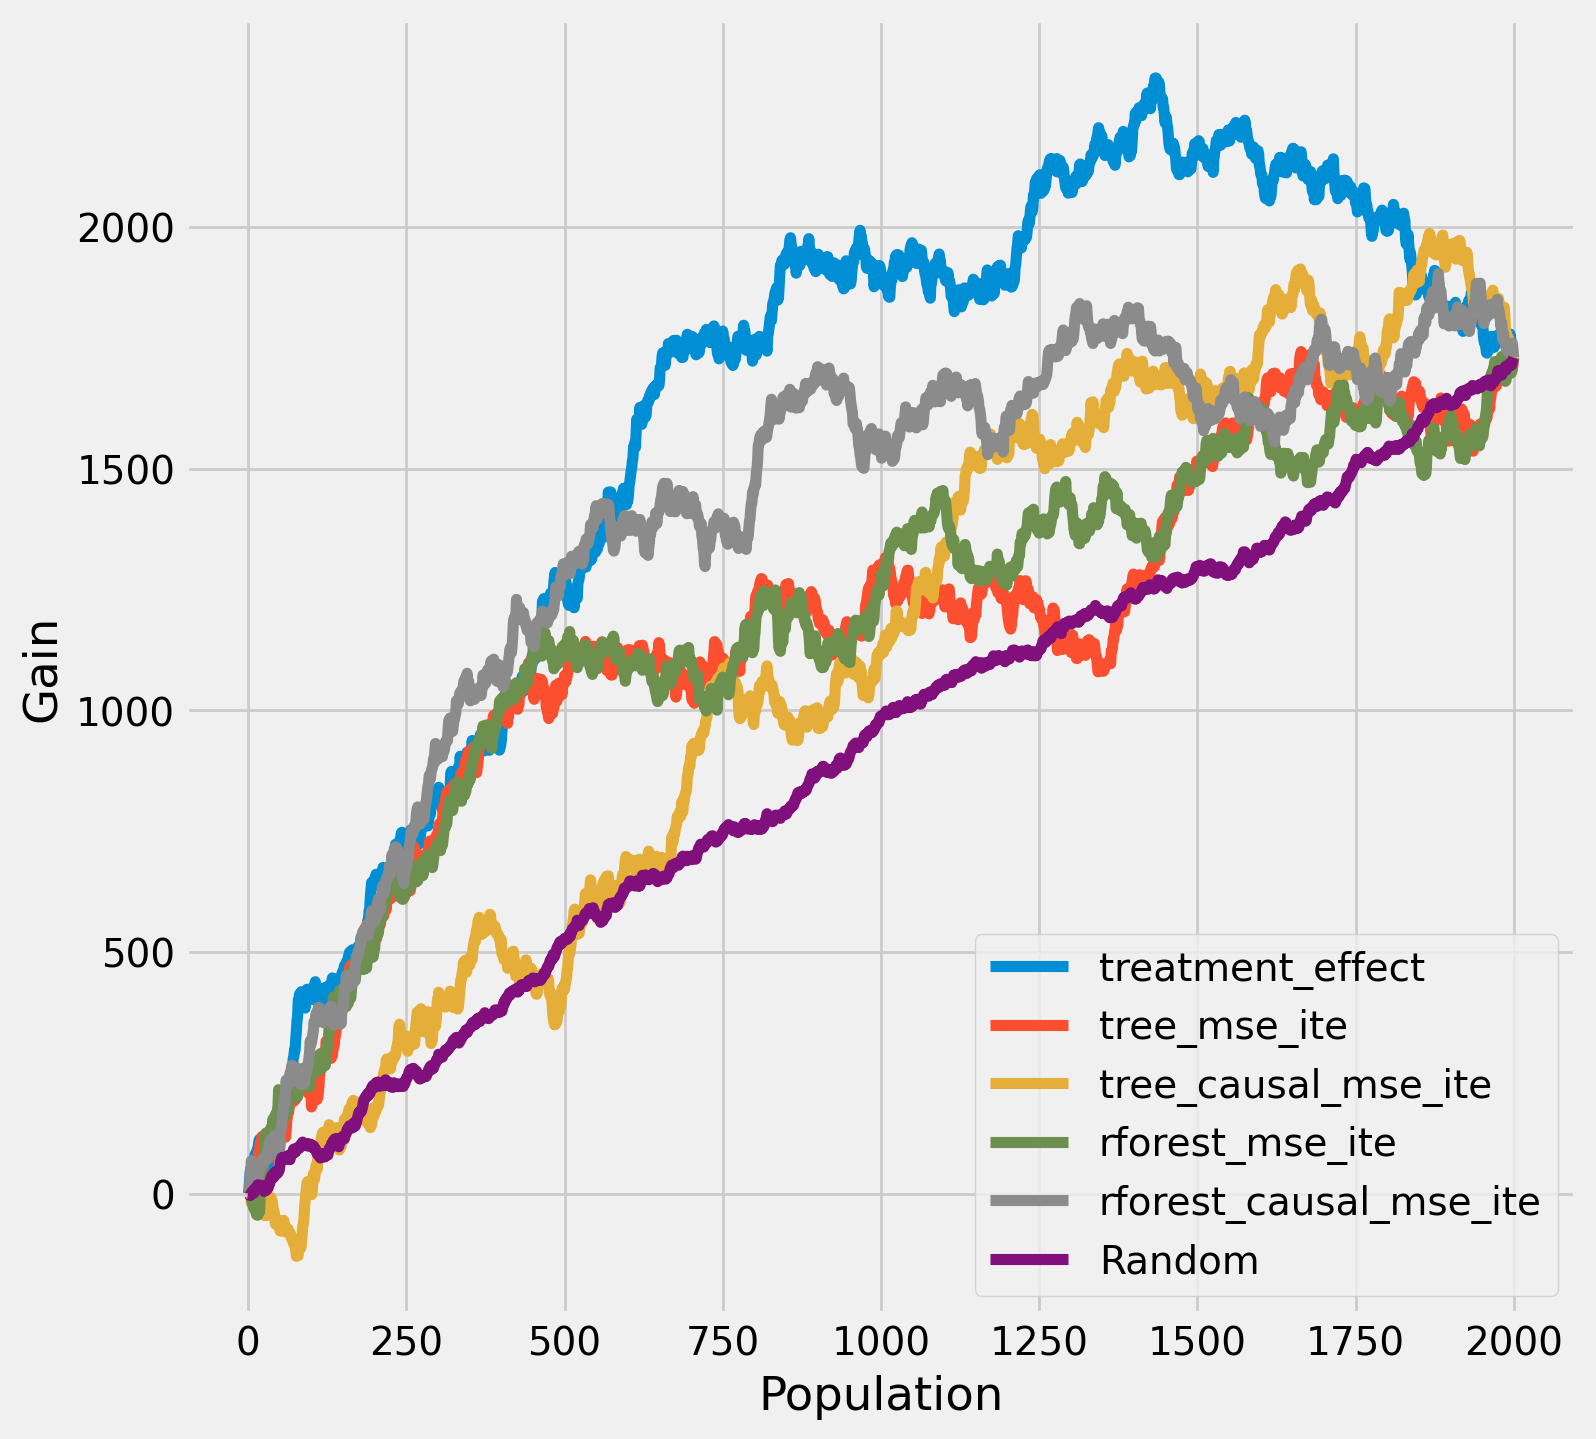

In [27]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test
         )

In [28]:
df_rforest2_fimp = pd.DataFrame({'importances': rforest2.feature_importances_, 'feature': feature_names})
df_rforest2_fimp = df_rforest2_fimp.sort_values(by=['importances'], ascending=False)
df_rforest2_fimp.head(10)

importances     feature
2      0.129070   feature_2
0      0.070669   feature_0
17     0.059027  feature_17
14     0.056364  feature_14
5      0.053766   feature_5
6      0.052928   feature_6
12     0.049534  feature_12
8      0.048613   feature_8
11     0.046610  feature_11
19     0.043384  feature_19

In [29]:
top10_features = df_rforest2_fimp.head(10)['feature'].tolist()

rforest3 = CausalRandomForestRegressor(criterion="causal_mse",  min_samples_leaf=200,
                                       control_name=0, n_estimators=50, n_jobs=4)
rforest3.fit(X=df_train[top10_features].values,
             treatment=df_train['treatment'].values,
             y=df_train['outcome'].values
             )
df_result['rforest_causal_mse_ite_top10'] = rforest3.predict(df_test[top10_features])
stat_columns.append('rforest_causal_mse_ite_top10')

#### Qini chart

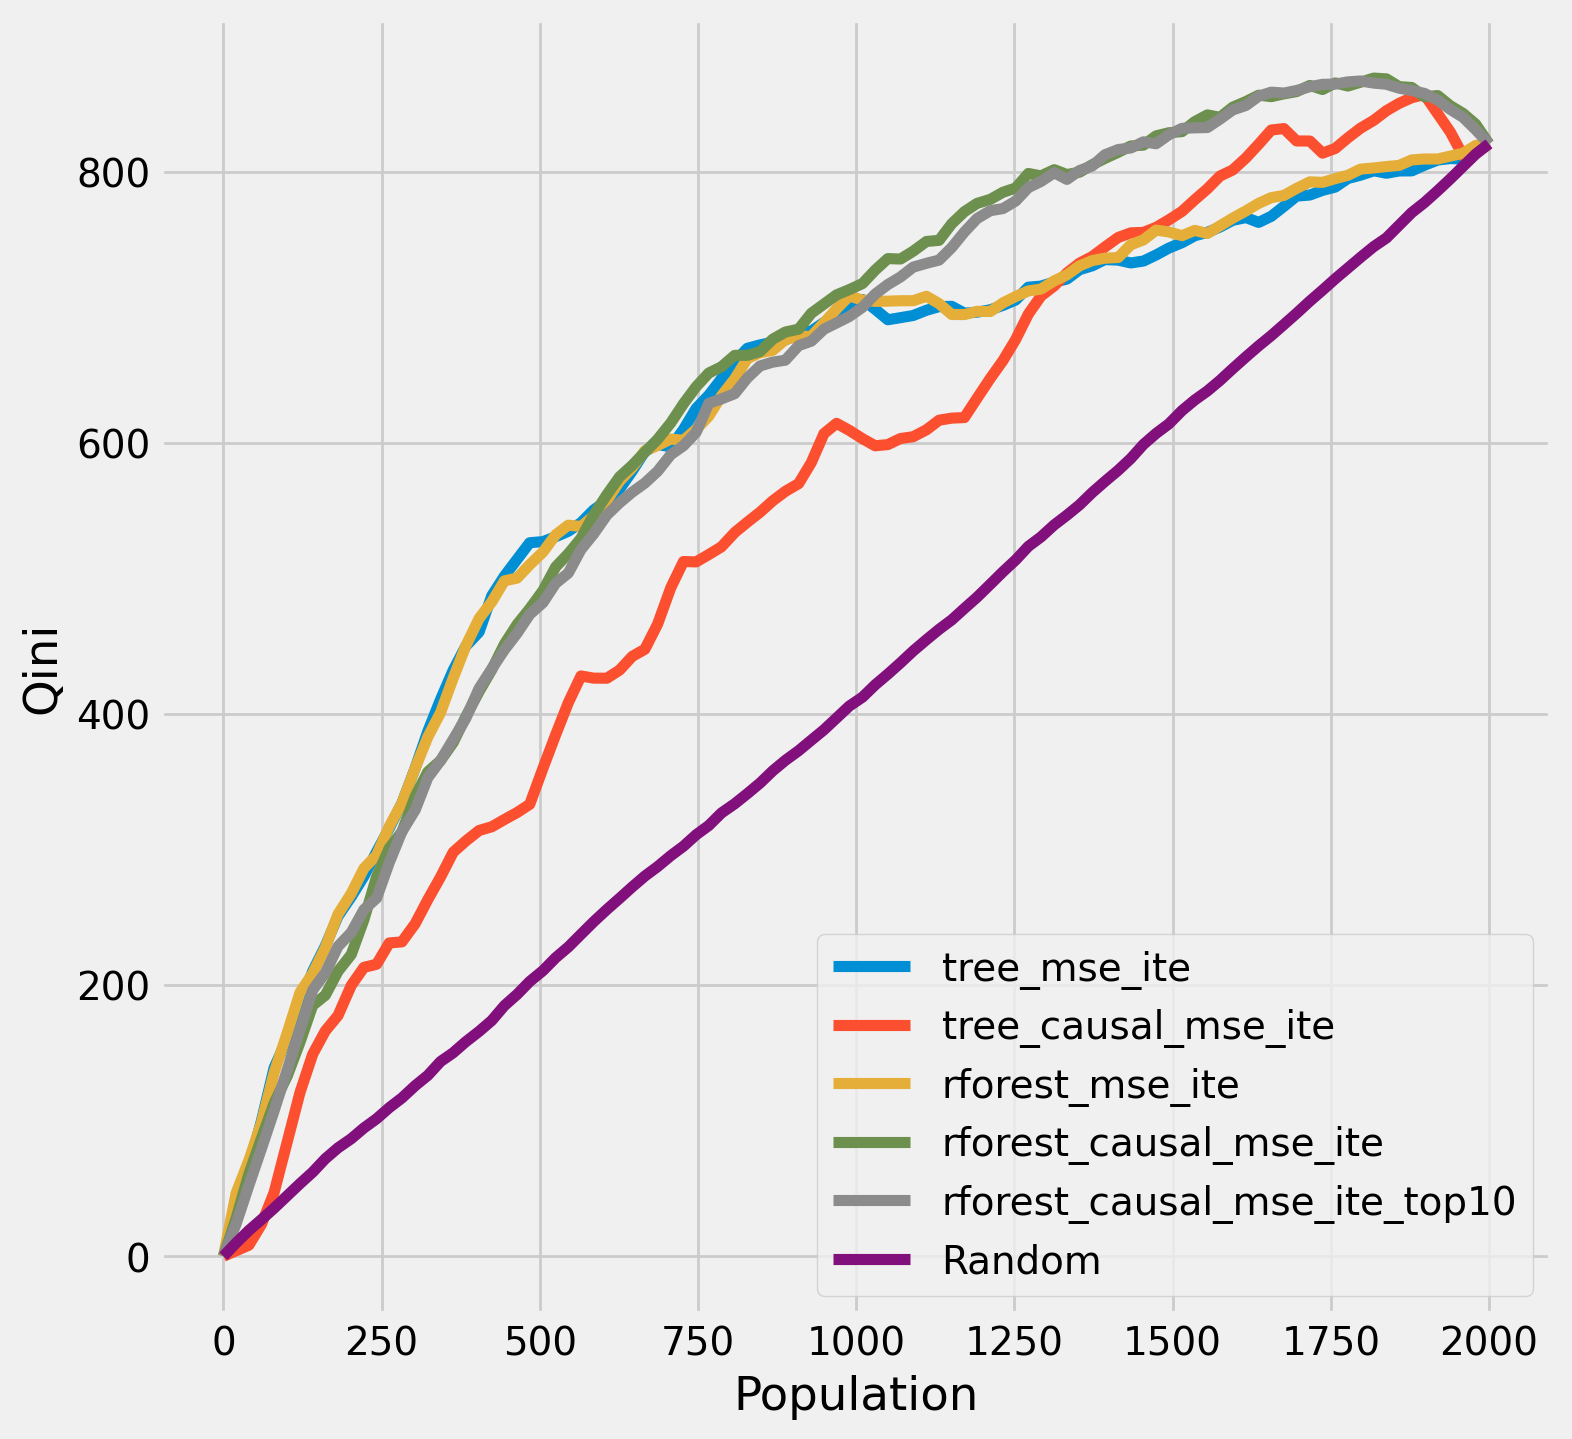

In [30]:
plot_qini(df_result[stat_columns],
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
         )

In [31]:
df_qini = qini_score(df_result[stat_columns],
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')

df_qini.sort_values(ascending=False)

rforest_causal_mse_ite          0.269309
rforest_causal_mse_ite_top10    0.260739
rforest_mse_ite                 0.238682
tree_mse_ite                    0.236528
tree_causal_mse_ite             0.168610
Random                          0.000000
dtype: float64

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

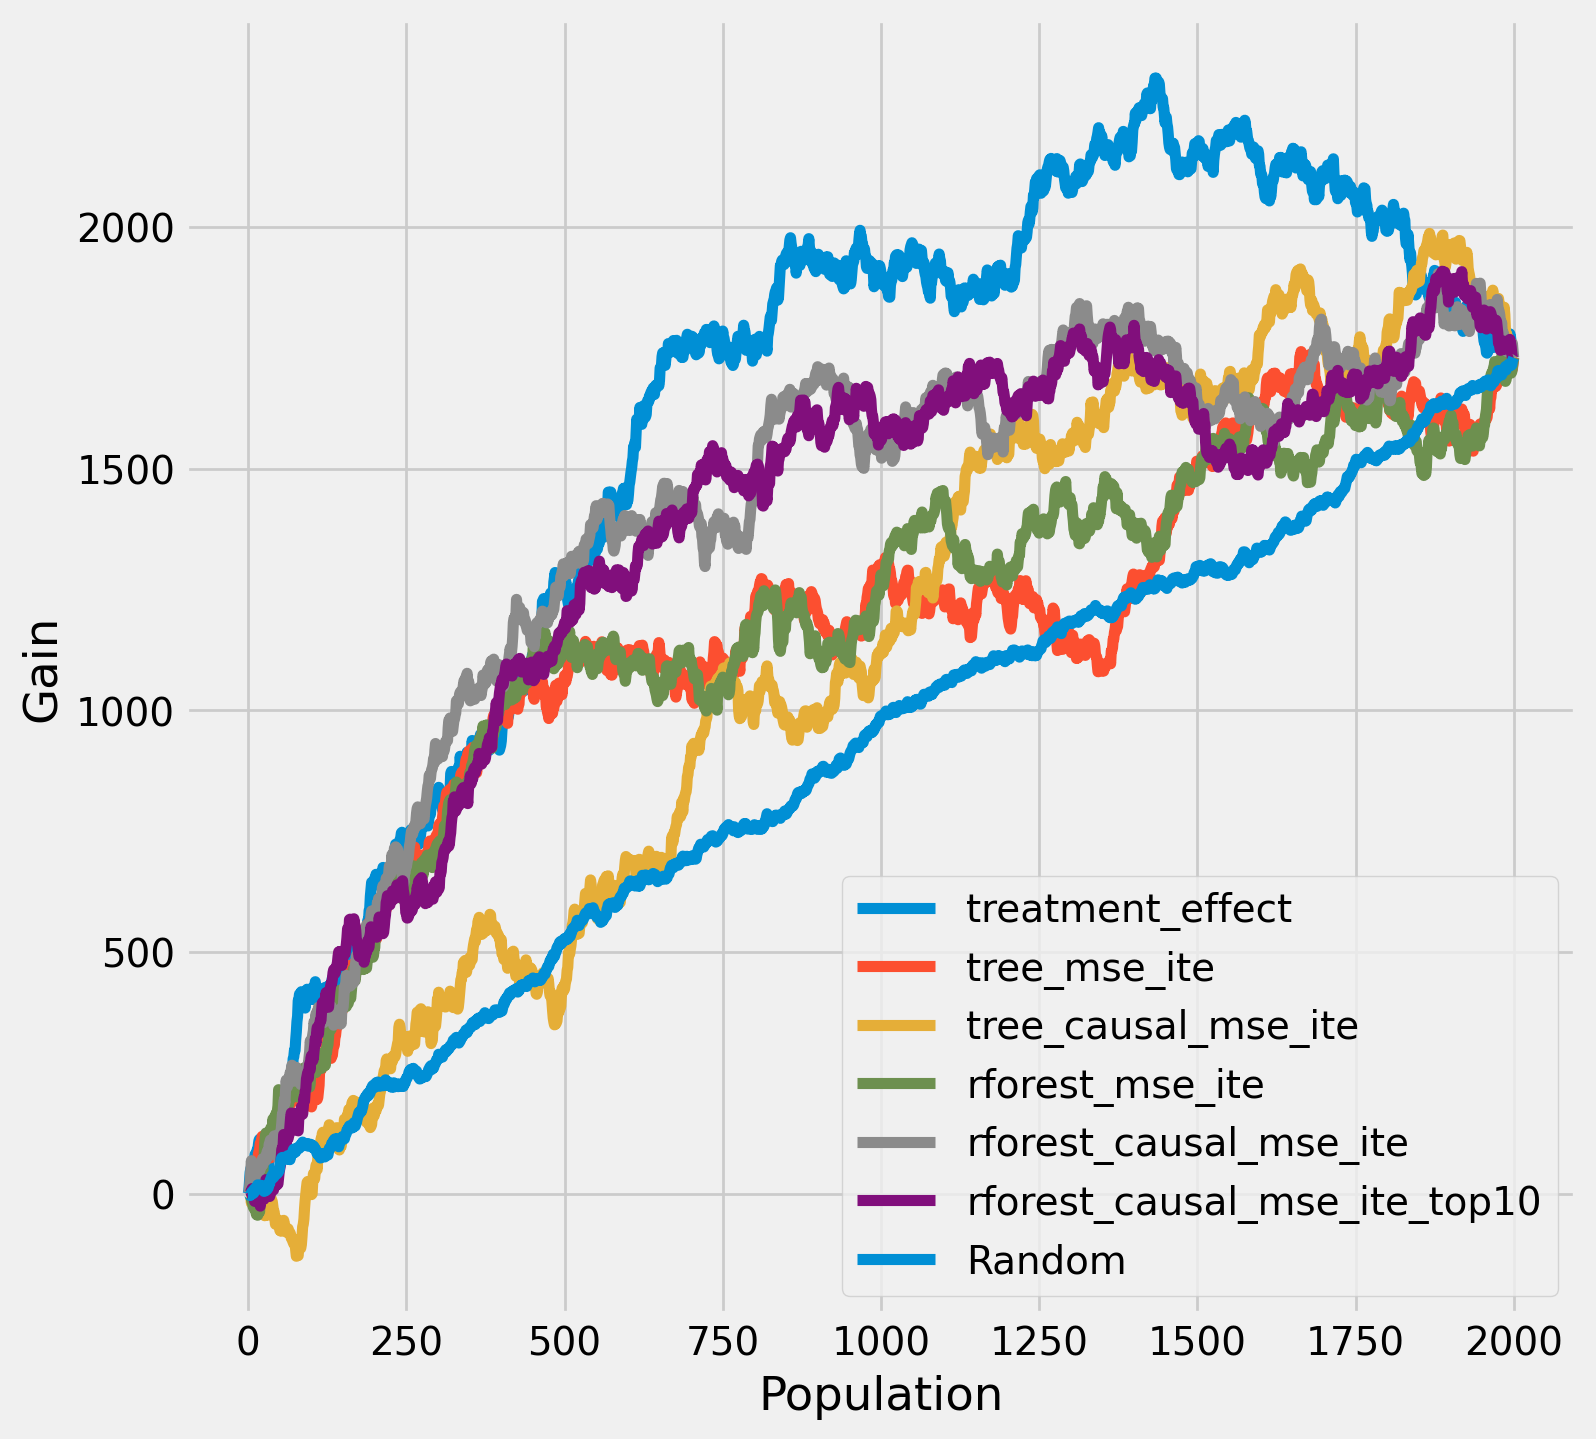

In [32]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test
         )

###  Meta-Learner Algorithms

In [33]:
X_train = df_train[feature_names].values
X_test = df_test[feature_names].values

# learner - DecisionTreeRegressor
# treatment learner - LinearRegression()

learner_x = BaseXRegressor(learner=DecisionTreeRegressor(), 
                           treatment_effect_learner=LinearRegression())
learner_s = BaseSRegressor(learner=DecisionTreeRegressor())
learner_t = BaseTRegressor(learner=DecisionTreeRegressor(), 
                           treatment_learner=LinearRegression())
learner_dr = BaseDRRegressor(learner=DecisionTreeRegressor(), 
                             treatment_effect_learner=LinearRegression())

learner_x.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_s.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_t.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_dr.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)

df_result['learner_x_ite'] = learner_x.predict(X_test)
df_result['learner_s_ite'] = learner_s.predict(X_test)
df_result['learner_t_ite'] = learner_t.predict(X_test)
df_result['learner_dr_ite'] = learner_dr.predict(X_test)

In [34]:
cate_dr = learner_dr.predict(X)
cate_x = learner_x.predict(X)
cate_s = learner_s.predict(X)
cate_t = learner_t.predict(X)

cate_tree1 = tree1.predict(X)
cate_tree2 = tree2.predict(X)
cate_rforest1 = rforest1.predict(X)
cate_rforest2 = rforest2.predict(X)

model_cate = (cate_tree1, cate_tree2, cate_rforest1, cate_rforest2, cate_x, cate_s, cate_t, cate_dr)
model_names = ('Tree (StandardMSE)', 'Tree (CausalMSE)', 
               'RForest (StandardMSE)', 'RForest (CausalMSE)',
               'X Learner', 'S Learner', 'T Learner', 'DR Learner'
              )

In [35]:
rows = 2
cols = 4
row_idxs = np.arange(rows)
col_idxs = np.arange(cols)

ax_idxs = np.dstack(np.meshgrid(col_idxs, row_idxs)).reshape(-1, 2) 

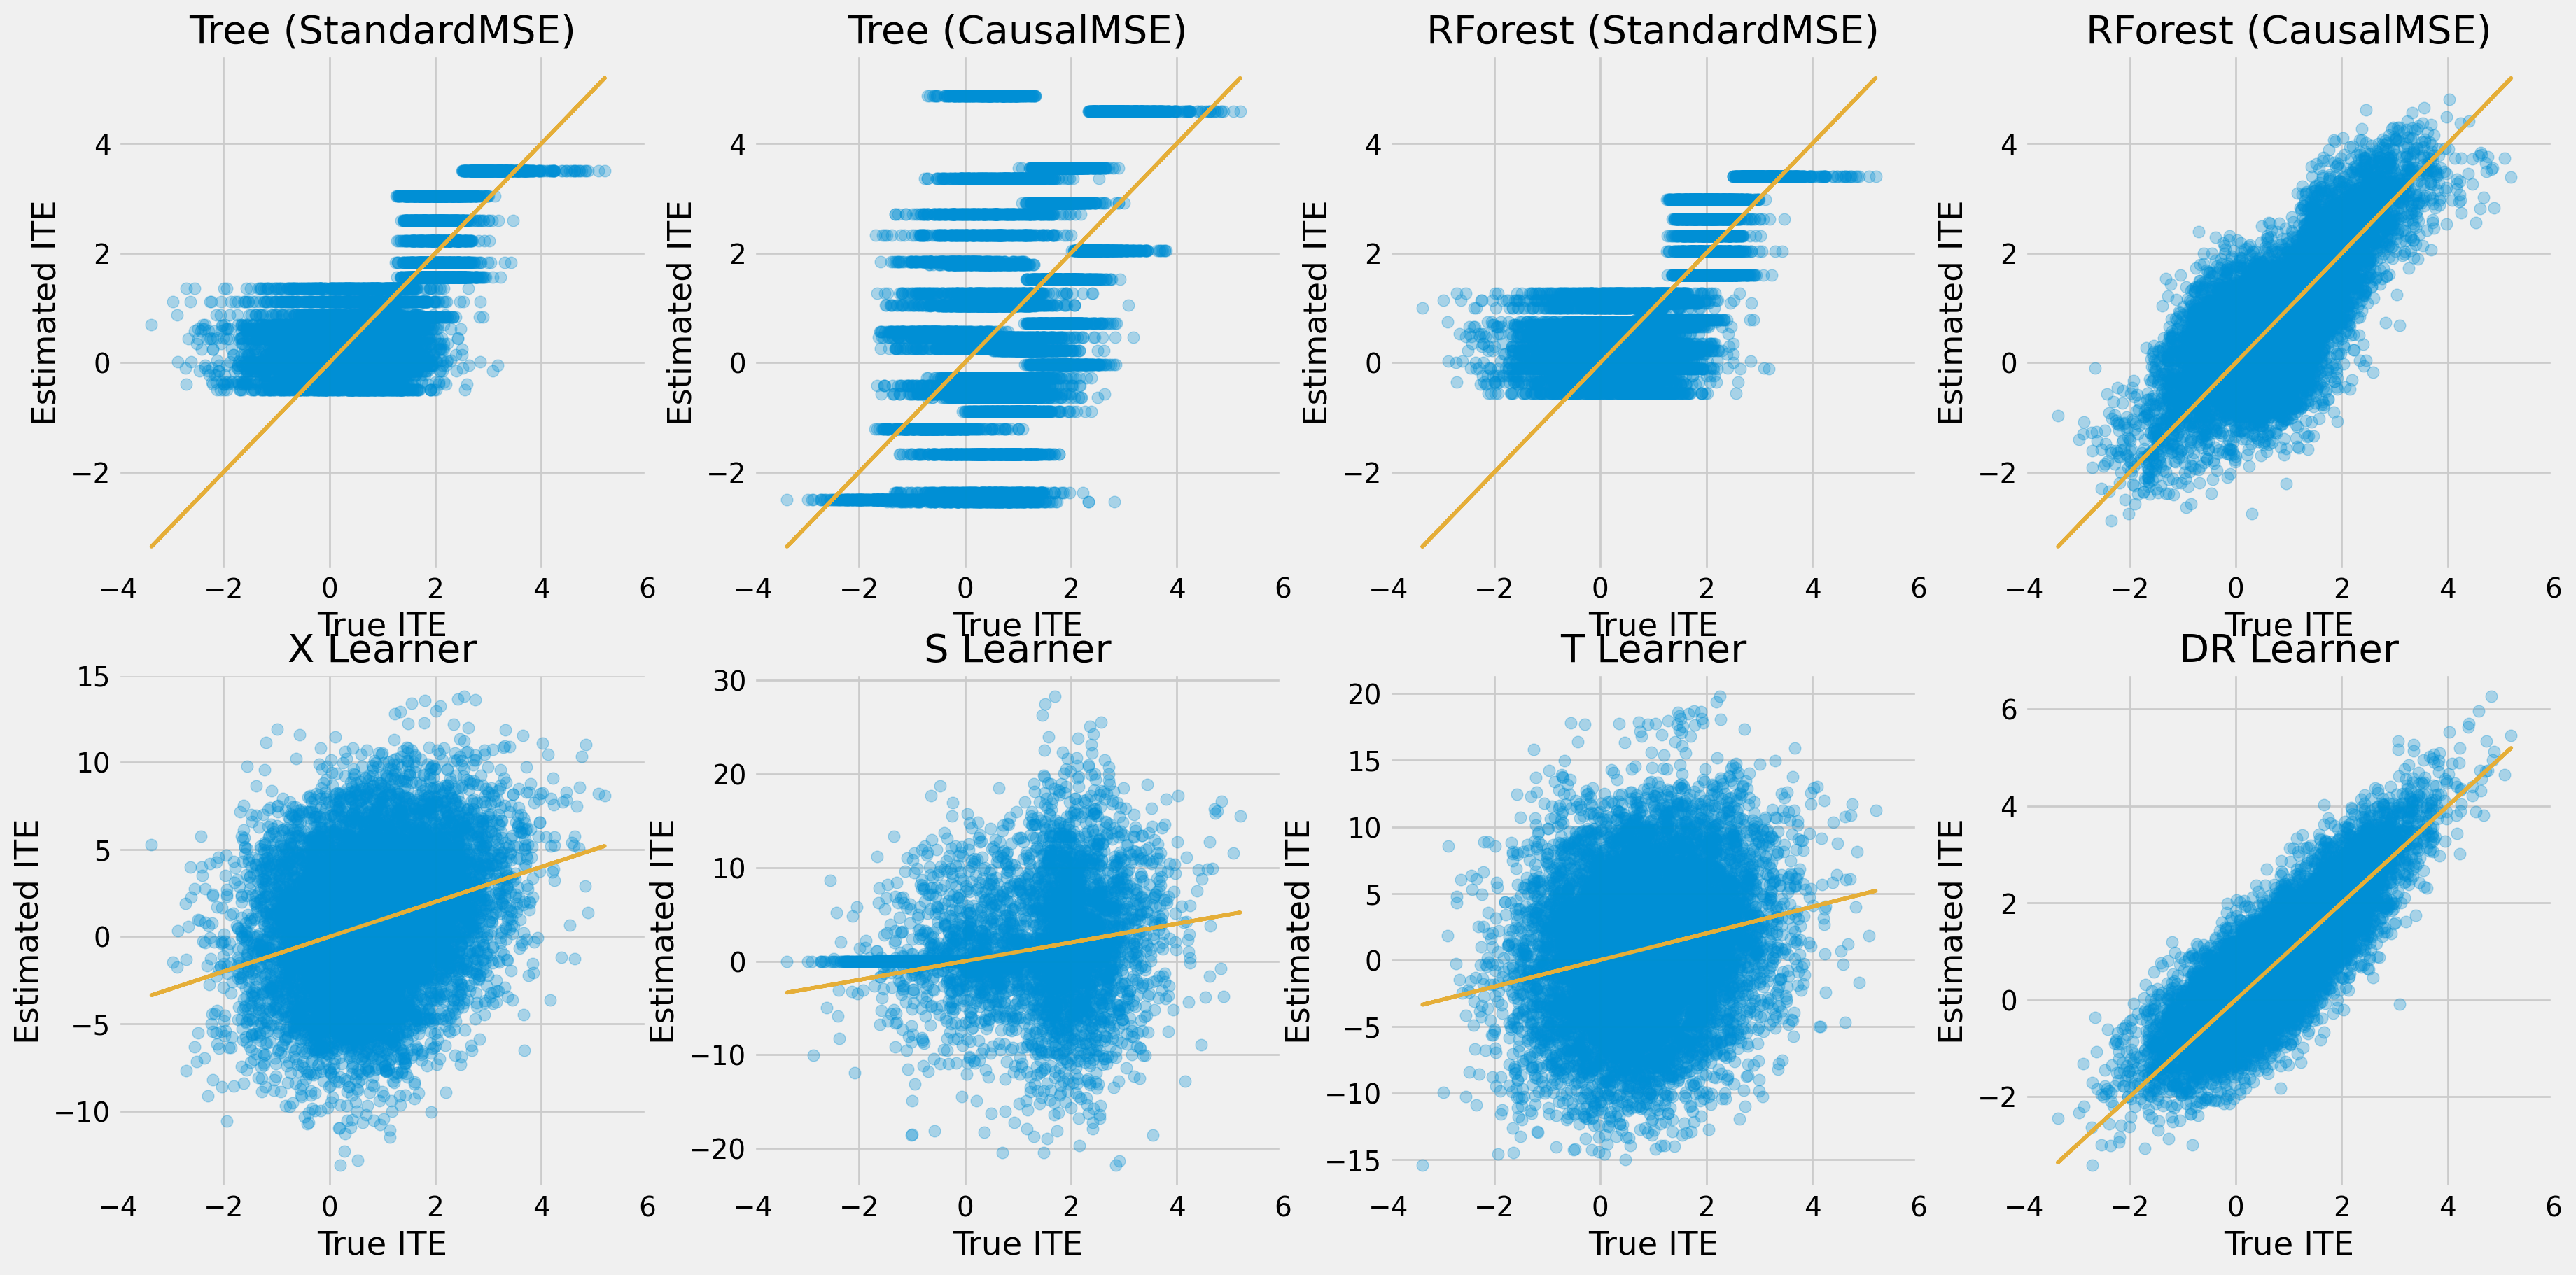

In [36]:
fig, ax = plt.subplots(rows, cols, figsize=(20, 10))


for ax_idx, cate, model_name in zip(ax_idxs, model_cate, model_names):
    col_id, row_id = ax_idx
    cur_ax = ax[row_id, col_id]
    cur_ax.scatter(tau, cate, alpha=0.3)
    cur_ax.plot(tau, tau, color='C2', linewidth=2)
    cur_ax.set_xlabel('True ITE')
    cur_ax.set_ylabel('Estimated ITE')
    cur_ax.set_title(model_name)
    cur_ax.set_xlim((-4, 6))

In [37]:
stat_columns.extend(['learner_x_ite', 'learner_s_ite', 'learner_t_ite', 'learner_dr_ite'])
stat_columns = list(set(stat_columns))

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

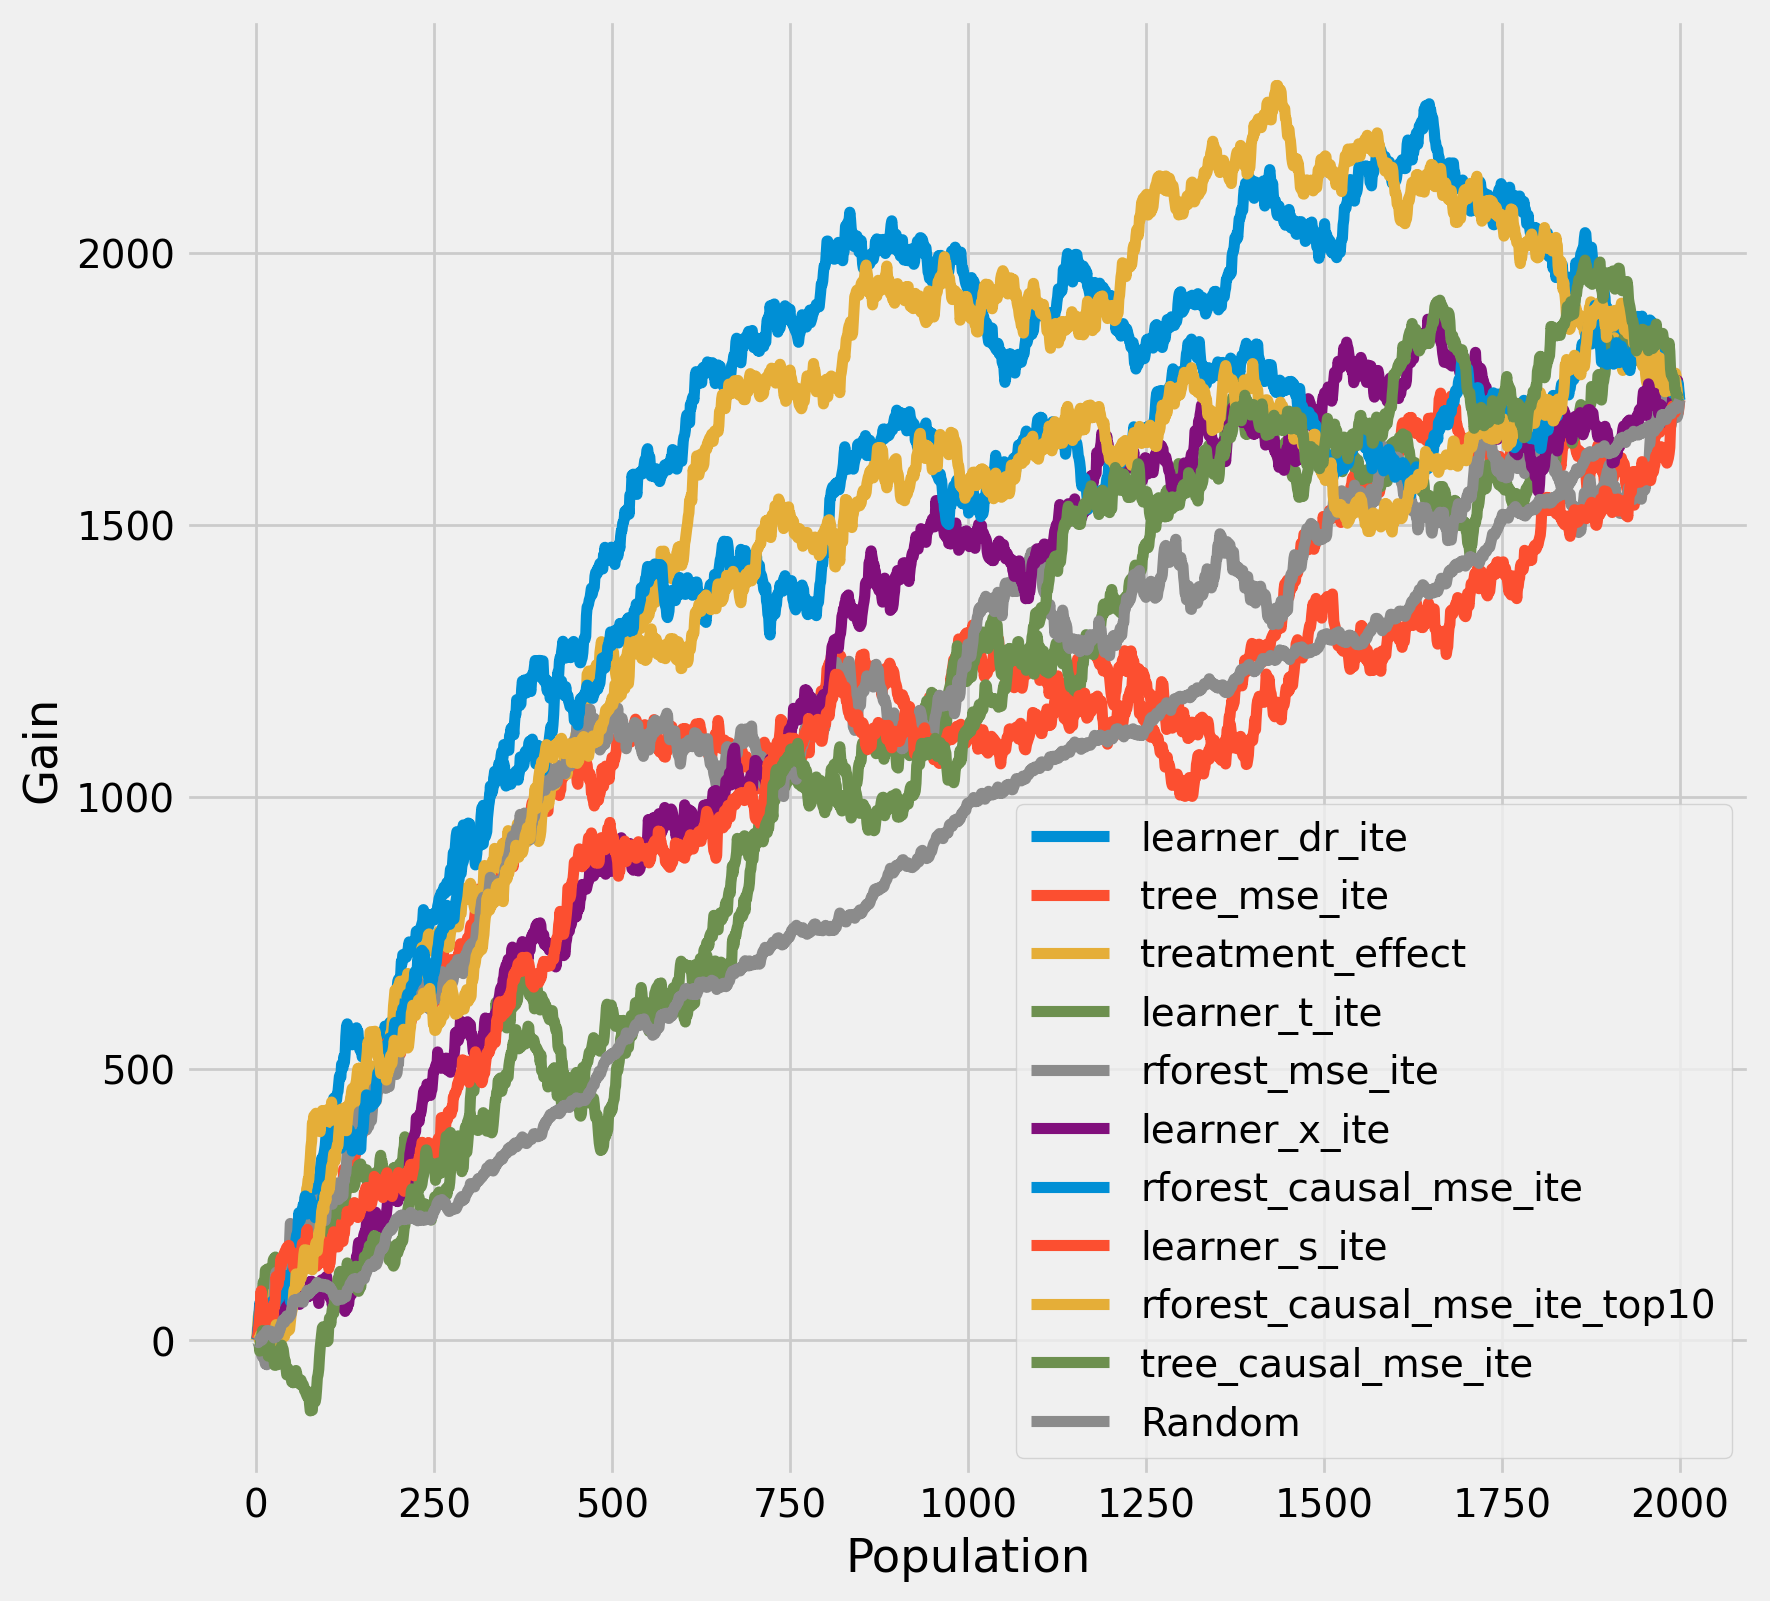

In [38]:
plot_gain(df_result[stat_columns], 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test,
          figsize=(9, 9),
         )

#### Qini chart

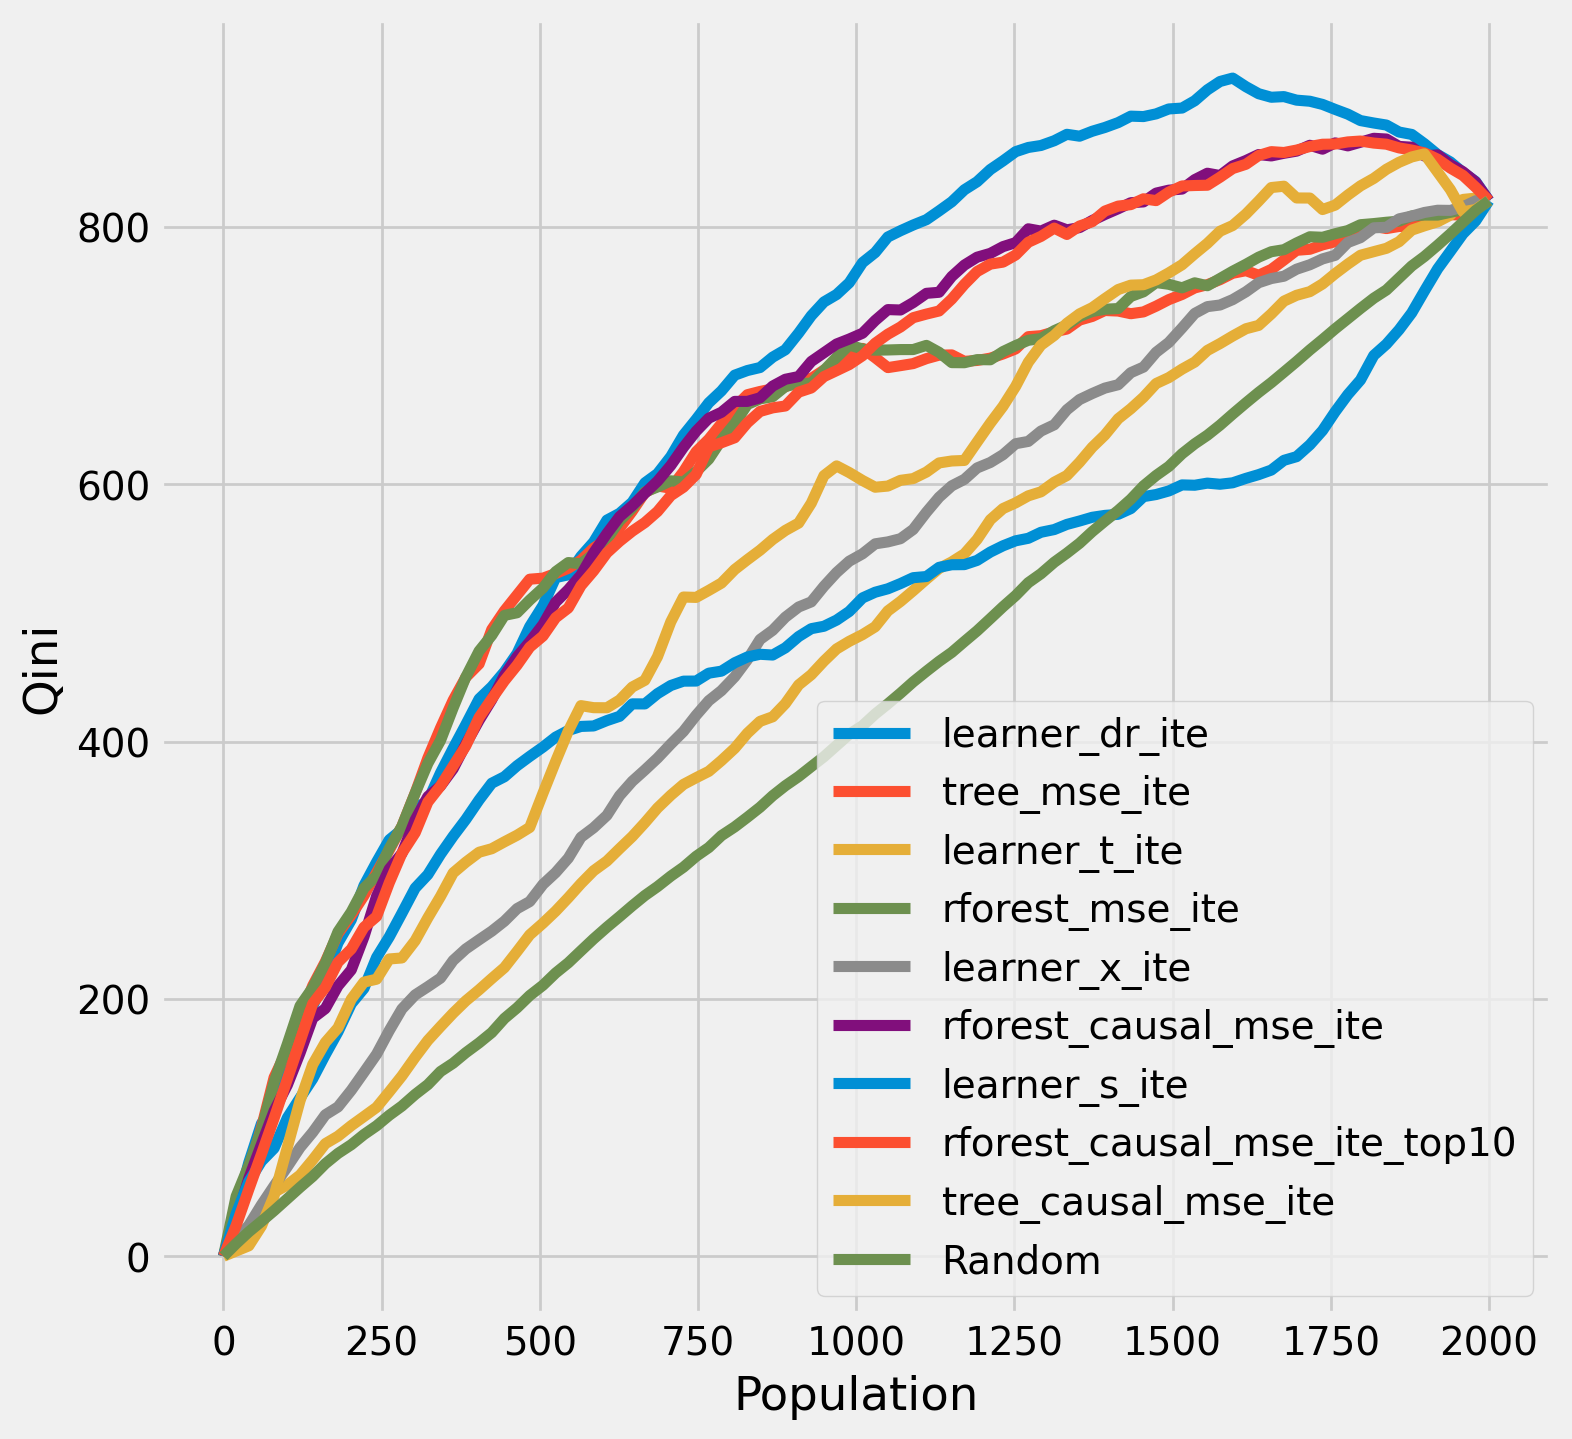

In [39]:
plot_qini(df_result[stat_columns],
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
         )

In [40]:
df_qini = qini_score(df_result[stat_columns],
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')
df_qini.sort_values(ascending=False)

learner_dr_ite                  0.308912
rforest_causal_mse_ite          0.269309
rforest_causal_mse_ite_top10    0.260739
rforest_mse_ite                 0.238682
tree_mse_ite                    0.236528
tree_causal_mse_ite             0.168610
learner_x_ite                   0.102460
learner_s_ite                   0.078386
learner_t_ite                   0.059568
Random                          0.000000
dtype: float64

---

### Bootstrap confidence intervals for individual treatment effects

In [41]:
alpha=0.05
tree = CausalTreeRegressor(criterion='causal_mse', control_name=0, min_samples_leaf=200, alpha=alpha)

In [42]:
# For time measurements
for n_jobs in (4, mp.cpu_count() - 1):
    for n_bootstraps in (10, 50, 100):
        print(f"n_jobs: {n_jobs} n_bootstraps: {n_bootstraps}" )
        tree.bootstrap_pool(
            X=X,
            treatment=w,
            y=y,
            n_bootstraps=n_bootstraps,
            bootstrap_size=10000,
            n_jobs=n_jobs,
            verbose=False
        )

n_jobs: 4 n_bootstraps: 10


100%|██████████| 10/10 [00:00<00:00, 24.10it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 10, 'bootstrap_size': 10000, 'n_jobs': 4, 'verbose': False} Elapsed time: 0.7078
n_jobs: 4 n_bootstraps: 50



100%|██████████| 50/50 [00:02<00:00, 23.34it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 50, 'bootstrap_size': 10000, 'n_jobs': 4, 'verbose': False} Elapsed time: 2.2313
n_jobs: 4 n_bootstraps: 100



100%|██████████| 100/100 [00:04<00:00, 22.80it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 100, 'bootstrap_size': 10000, 'n_jobs': 4, 'verbose': False} Elapsed time: 4.4469
n_jobs: 11 n_bootstraps: 10



100%|██████████| 10/10 [00:00<00:00, 28.01it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 10, 'bootstrap_size': 10000, 'n_jobs': 11, 'verbose': False} Elapsed time: 0.6781
n_jobs: 11 n_bootstraps: 50



100%|██████████| 50/50 [00:01<00:00, 34.10it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 50, 'bootstrap_size': 10000, 'n_jobs': 11, 'verbose': False} Elapsed time: 1.5928
n_jobs: 11 n_bootstraps: 100



100%|██████████| 100/100 [00:02<00:00, 35.13it/s]

Function: bootstrap_pool Kwargs:{'n_bootstraps': 100, 'bootstrap_size': 10000, 'n_jobs': 11, 'verbose': False} Elapsed time: 3.0379


In [43]:
te, te_lower, te_upper = tree.fit_predict(
        X=df_train[feature_names].values,
        treatment=df_train["treatment"].values,
        y=df_train["outcome"].values,
        return_ci=True,
        n_bootstraps=500,
        bootstrap_size=5000,
        n_jobs=mp.cpu_count() - 1,
        verbose=False)

100%|██████████| 500/500 [00:09<00:00, 54.40it/s]


Function: bootstrap_pool Kwargs:{'n_bootstraps': 500, 'bootstrap_size': 5000, 'n_jobs': 11, 'verbose': False} Elapsed time: 9.3697


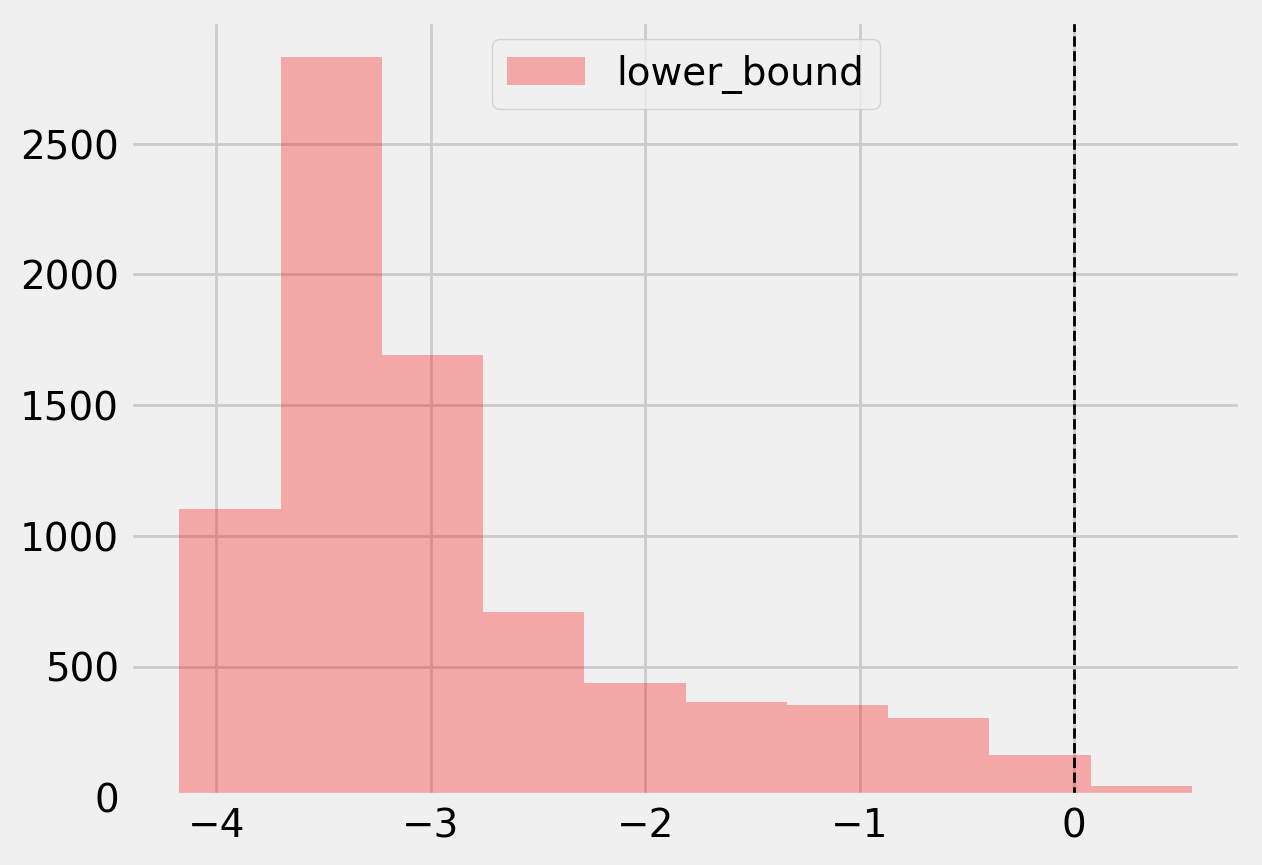

In [44]:
plt.hist(te_lower, color='red', alpha=0.3, label='lower_bound')
plt.axvline(x = 0, color = 'black', linestyle='--', lw=1, label='')
plt.legend()
plt.show()

In [45]:
# Significant estimates for negative and positive individual effects
# Default alpha = 0.05

bootstrap_neg = te[(te_lower < 0) & (te_upper < 0)]
bootstrap_pos = te[(te_lower > 0) & (te_upper > 0)]
print(bootstrap_neg.shape, bootstrap_pos.shape)

(0,) (60,)


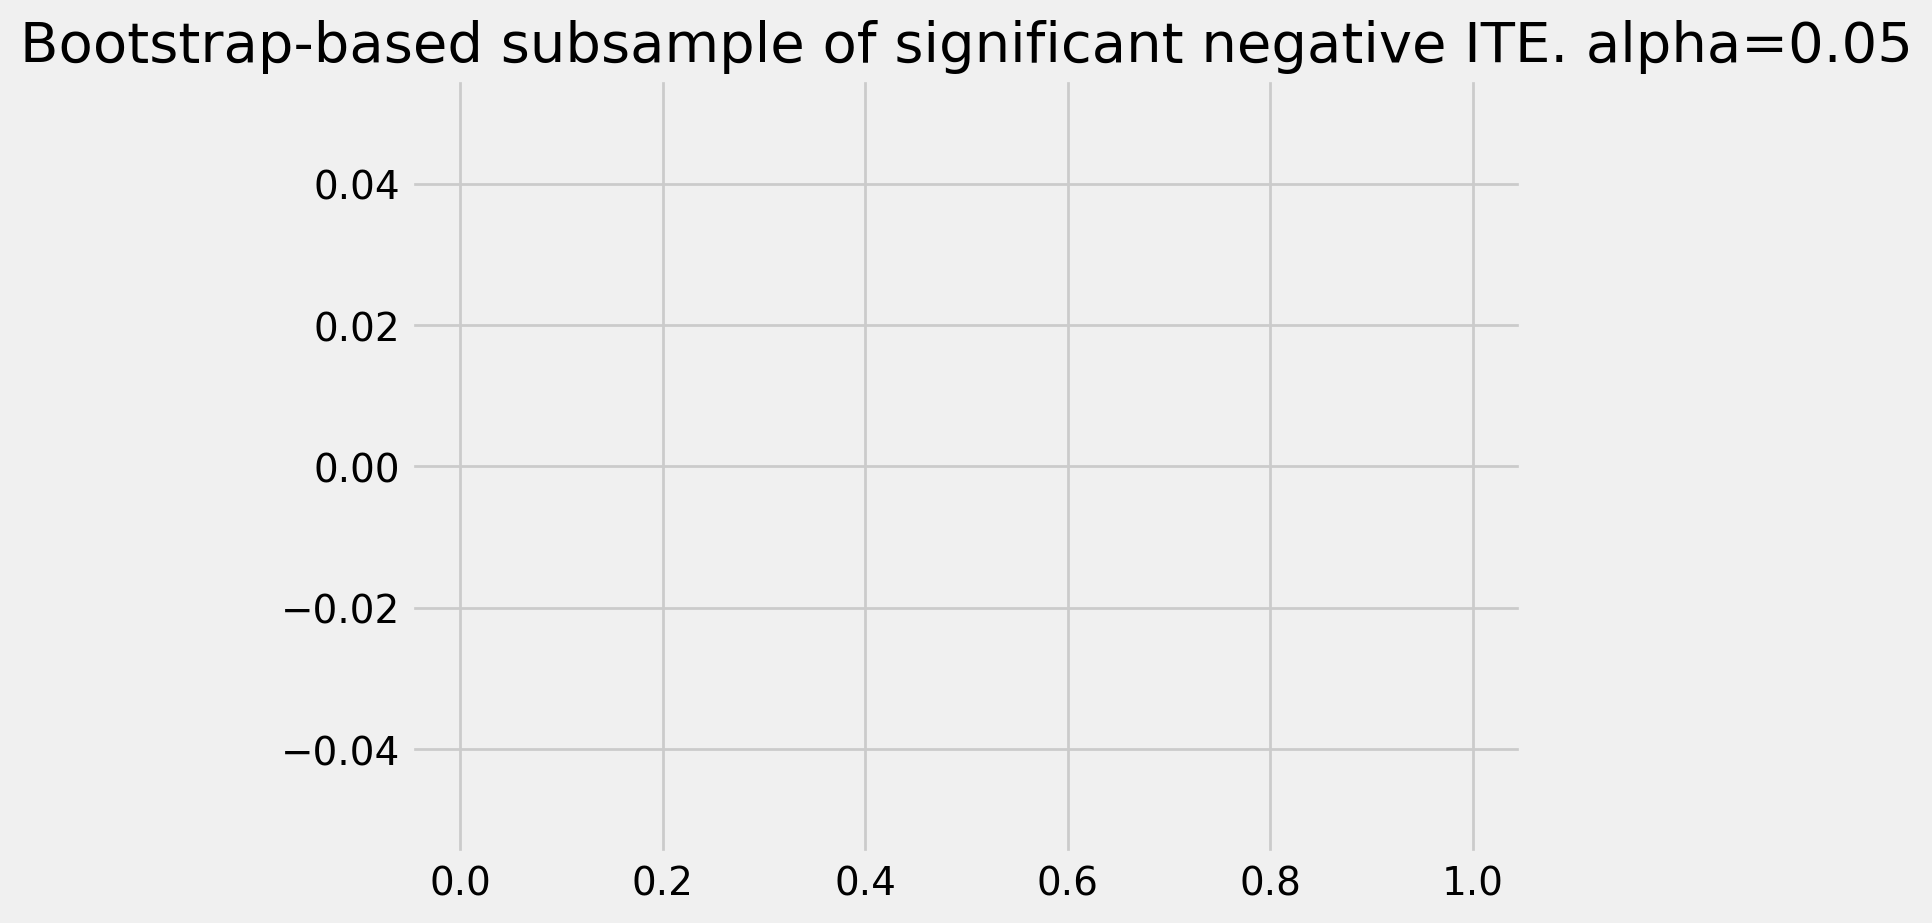

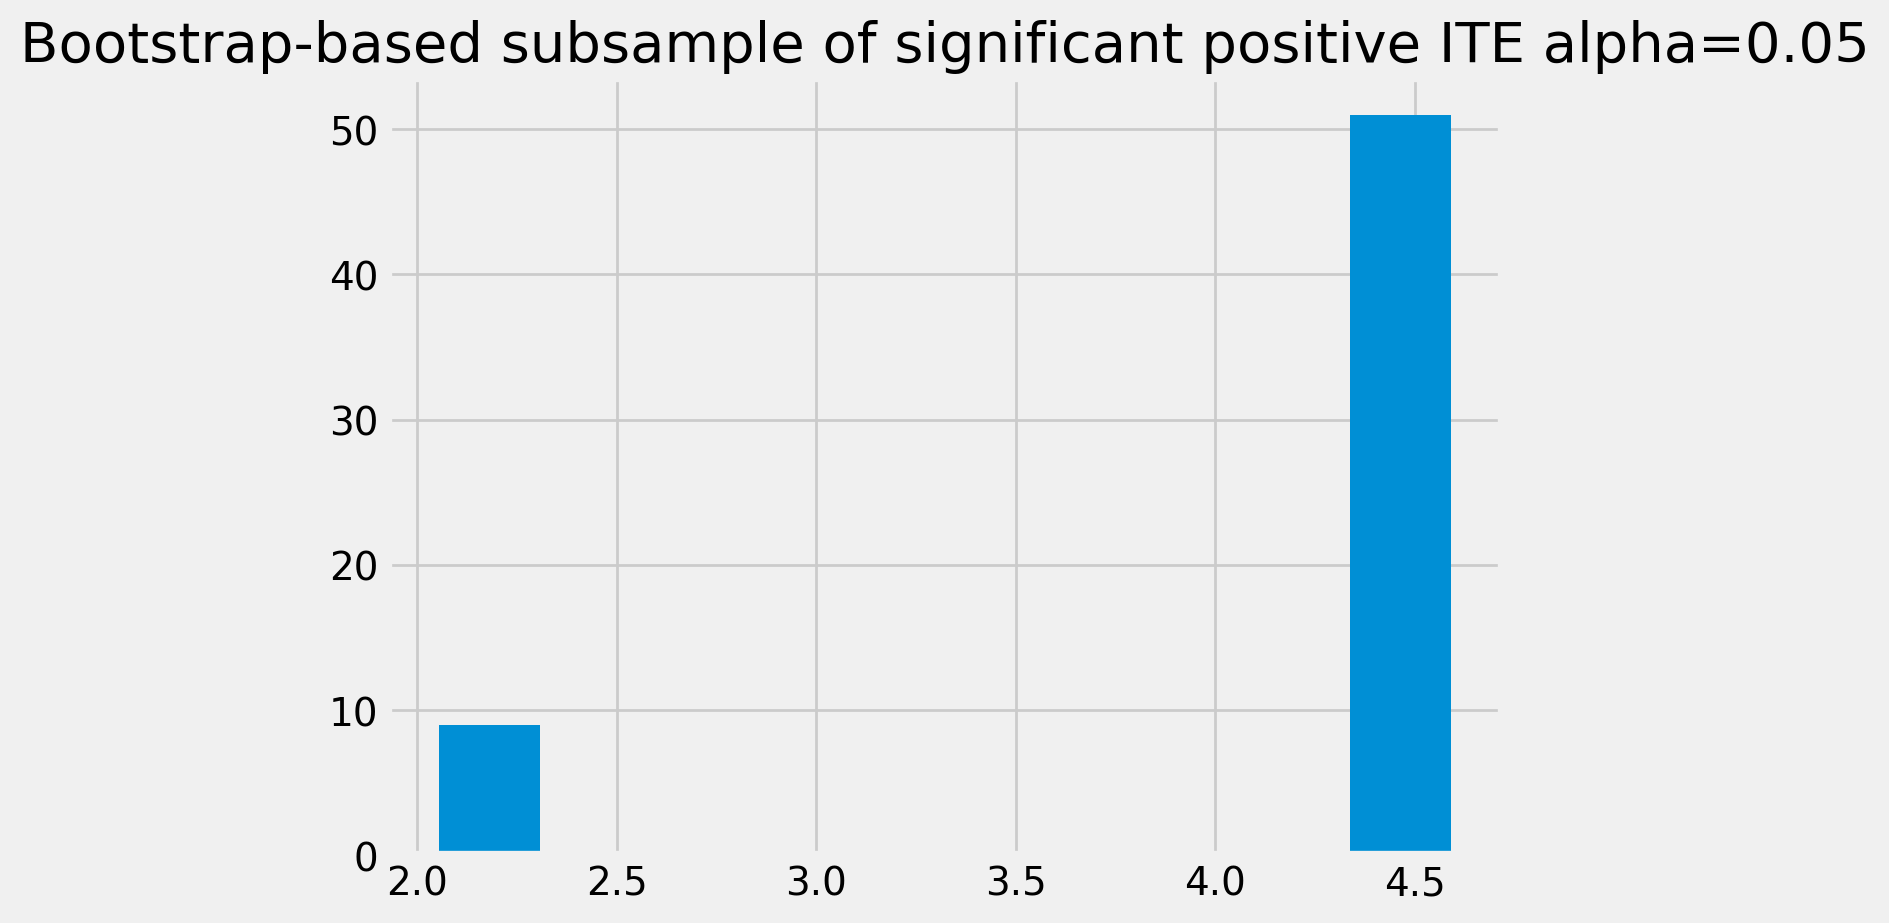

In [46]:
plt.hist(bootstrap_neg)
plt.title(f'Bootstrap-based subsample of significant negative ITE. alpha={alpha}')
plt.show()

plt.hist(bootstrap_pos)
plt.title(f'Bootstrap-based subsample of significant positive ITE alpha={alpha}')
plt.show()

### Average treatment effect

In [47]:
tree = CausalTreeRegressor(criterion='causal_mse', control_name=0, min_samples_leaf=200, alpha=alpha)
te, te_lb, te_ub = tree.estimate_ate(X=X, treatment=w, y=y)
print('ATE:', te, 'Bounds:', (te_lb, te_ub ), 'alpha:', alpha)

ATE: 0.8484039088635743 Bounds: (0.8480211259705724, 0.8487866917565762) alpha: 0.05


### CausalRandomForestRegressor ITE std

In [48]:
crforest = CausalRandomForestRegressor(criterion="causal_mse",  min_samples_leaf=200,
                                       control_name=0, n_estimators=50, n_jobs=mp.cpu_count()-1)
crforest.fit(X=df_train[feature_names].values,
             treatment=df_train['treatment'].values,
             y=df_train['outcome'].values
             )

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=50, n_jobs=11)

In [49]:
crforest_te_pred = crforest.predict(df_test[feature_names])
crforest_test_var = crforest.calculate_error(X_train=df_train[feature_names].values,
                                        X_test=df_test[feature_names].values)
crforest_test_std = np.sqrt(crforest_test_var)

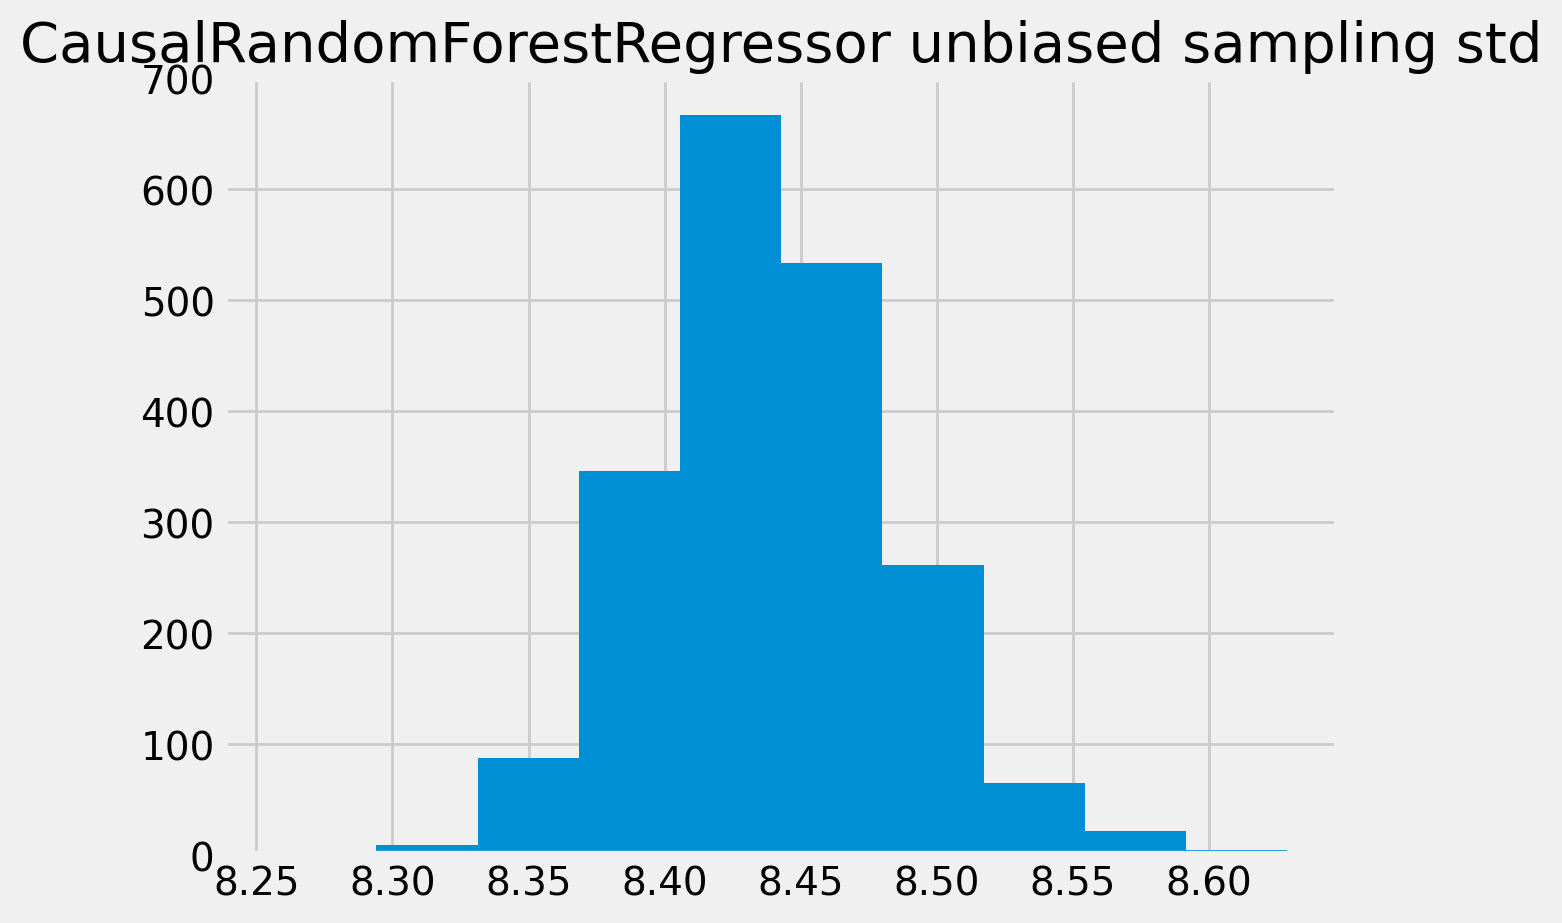

In [50]:
plt.hist(crforest_test_std)
plt.title("CausalRandomForestRegressor unbiased sampling std")
plt.show()